# **Spectrograms & Convolutional NN**

The following code utilizes the [librosa](https://github.com/librosa/librosa) library to extract spectrograms and melgrams from audio files and train a CNN model. When applied to the test set, the model achieves an accuracy of 66% and an F1 (macro) score of 65%.

In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/GitHub/MarineMammalSoundClassification/'
%cd /content/drive/My Drive/GitHub/MarineMammalSoundClassification/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1oJSL58N419Ve8pd0wCvgXEy52hLM2tJN/MarineMammalSoundClassification


In [2]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy


## **Extract and Save Spectrograms**

In [ ]:
def segment_audio(file_path, segment_length=2.0):
    """
    Segments an audio file into equal parts of specified length with zero padding for the last segment if needed.

    Parameters:
    file_path (str): Path to the input audio file.
    segment_length (float): Length of each segment in seconds. Default is 2.0 seconds.

    Returns:
    list: List of audio segments.
    int: Sample rate of the audio file.
    """
    y, sr = librosa.load(file_path, sr=None)
    segment_samples = int(segment_length * sr)
    total_samples = len(y)

    segments = []
    for start in range(0, total_samples, segment_samples):
        end = start + segment_samples
        segment = y[start:end]
        if len(segment) < segment_samples:
            # Zero-pad the last segment if needed
            segment = np.pad(segment, (0, segment_samples - len(segment)), 'constant')
        segments.append(segment)

    return segments, sr

def display_spectrogram(data):
    """
    Displays a spectrogram from given spectrogram data.

    Parameters:
    data (ndarray): Spectrogram data to display.
    """
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(data, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Linear-frequency power spectrogram')
    plt.show()

def create_spectrogram(segment):
    """
    Creates a spectrogram for a given audio segment.

    Parameters:
    segment (ndarray): Audio segment data.

    Returns:
    ndarray: Spectrogram data in decibels.
    """
    S = librosa.stft(segment)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    # display_spectrogram(S_db)
    return S_db

def create_melgram(segment, sr):
    """
    Creates a mel-spectrogram for a given audio segment.

    Parameters:
    segment (ndarray): Audio segment data.
    sr (int): Sample rate of the audio segment.

    Returns:
    ndarray: Mel-spectrogram data in decibels.
    """
    S = librosa.feature.melspectrogram(y=segment, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)
    # display_spectrogram(S_db)
    return S_db

def resize_spectrogram(data, n):
    """
    Resize a spectrogram to a desired n x n size.

    Parameters:
    data (np.array): Input spectrogram with shape (height, width).
    n (int): Desired size for the output spectrogram (n x n).

    Returns:
    np.array: Resized spectrogram with shape (n, n).
    """
    # Calculate the current size of the spectrogram
    current_height, current_width = data.shape

    # Calculate the zoom factors for height and width to reach the desired size
    zoom_factor_height = n / current_height
    zoom_factor_width = n / current_width

    # Resize the spectrogram
    D_resized = scipy.ndimage.zoom(data, (zoom_factor_height, zoom_factor_width))

    return D_resized

In [ ]:
if not os.path.exists('spectrograms'):
   os.makedirs('spectrograms')

In [ ]:
def create_pkl_with_spectrograms(set_name, seg_dur, n_size):
    """
    Create pickle files containing spectrograms, mel-spectrograms, class labels, and segment counts
    from audio files segmented into equal parts with zero padding if needed.

    Parameters:
    set_name (str): Name of the dataset directory (train/val/test) located in the 'data_split' directory.
    seg_dur (float): Duration of each segment in seconds.
    n_size (int): Desired size for the output spectrograms and mel-spectrograms (n x n).

    The function generates and saves the following pickle files:
    - 'spectrograms/{seg_dur}_secs/{set_name}_specs.pkl': List of resized spectrograms.
    - 'spectrograms/{seg_dur}_secs/{set_name}_mels.pkl': List of resized mel-spectrograms.
    - 'spectrograms/{seg_dur}_secs/{set_name}_classes.pkl': List of class labels corresponding to the segments.
    - 'spectrograms/{seg_dur}_secs/{set_name}_segments.pkl': List of segment counts per file.
    """
    set_dir = os.path.join("data_split", set_name)
    set_classes = os.listdir(set_dir)
    dirs = [os.path.join(set_dir, c) for c in set_classes]

    spectrograms = []
    melgrams = []
    classes = []
    seg_per_file = []

    # Process each class directory
    for d in dirs:
        class_name = os.path.basename(d)  # Class name (directory name)
        files_list = os.listdir(d)  # List of audio files in the class directory
        for file_name in files_list:
            file_path = os.path.join(d, file_name)  # Full path to the audio file
            segments, sr = segment_audio(file_path, seg_dur)  # Segment the audio file
            seg_per_file.append(len(segments)) # Calculate the number of segments for the audio file

            # Process each segment
            for i, segment in enumerate(segments):
                spectrogram = create_spectrogram(segment)
                r_spectrogram = resize_spectrogram(spectrogram, n_size)
                melgram = create_melgram(segment, sr)
                r_melgram = resize_spectrogram(melgram, n_size)
                classes.append(class_name)
                spectrograms.append(r_spectrogram)
                melgrams.append(r_melgram)

    sub_folder = os.path.join('spectrograms', str(seg_dur) + '_secs')
    if not os.path.exists(sub_folder):
        os.makedirs(sub_folder)

    # Save spectrograms to a pickle file
    with open(os.path.join(sub_folder, set_name + '_specs.pkl'), 'wb') as f:
        pickle.dump(spectrograms, f)

    # Save mel-spectrograms to a pickle file
    with open(os.path.join(sub_folder, set_name + '_mels.pkl'), 'wb') as f:
        pickle.dump(melgrams, f)

    # Save class labels to a pickle file
    with open(os.path.join(sub_folder, set_name + '_classes.pkl'), 'wb') as f:
        pickle.dump(classes, f)

    # Save segment counts per file to a pickle file
    with open(os.path.join(sub_folder, set_name + '_segments.pkl'), 'wb') as f:
        pickle.dump(seg_per_file, f)


In [ ]:
for set_name in ['train', 'val', 'test']:
  create_pkl_with_spectrograms(set_name, 5.0, 128)

## **Convolutional Neural Network**

The [TensorFlow](https://www.tensorflow.org/) library was used to set up and train the model.

In [3]:
import pickle
import statistics
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [6]:
def load_data(data_path, classes_path):
    """
    Loads and preprocesses spectrogram data and class labels from pickle files.

    Parameters:
    data_path (str): Path to the pickle file containing spectrogram data.
    classes_path (str): Path to the pickle file containing class labels.

    Returns:
    tuple: A tuple containing:
        - X (np.array): Normalized spectrogram data.
        - y (np.array): One-hot encoded class labels.
        - encoder (LabelEncoder): Fitted LabelEncoder instance for decoding labels.
    """
    with open(data_path, 'rb') as f:
        X = pickle.load(f)
    with open(classes_path, 'rb') as f:
        classes = pickle.load(f)

    # Normalize spectrograms
    X = X / np.max(X)

    encoder = LabelEncoder()
    y = encoder.fit_transform(classes)
    y = to_categorical(y, num_classes=28)

    return np.array(X), np.array(y), encoder

def create_model(input_shape, num_classes):
    """
    Creates and compiles a Convolutional Neural Network (CNN) model.

    Parameters:
    input_shape (tuple): Shape of the input data (height, width, channels).
    num_classes (int): Number of output classes.

    Returns:
    tensorflow.keras.Model: The compiled CNN model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)),
    model.add(layers.MaxPooling2D(pool_size=(2, 2))),
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu')),
    model.add(layers.MaxPooling2D(pool_size=(2, 2))),
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten()),
    model.add(layers.Dense(128, activation='relu')),
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, trainX, trainY, valX, valY, epochs=20, batch_size=32, patience=5):
    """
    Trains the given model using the provided training and validation data.

    Args:
    model (tensorflow.keras.Model): The Keras model to be trained.
    trainX (numpy.ndarray): Training data features.
    trainY (numpy.ndarray): Training data labels.
    valX (numpy.ndarray): Validation data features.
    valY (numpy.ndarray): Validation data labels.
    epochs (int, optional): The number of epochs to train the model. Defaults to 20.
    batch_size (int, optional): The batch size to use during training. Defaults to 32.
    patience (int, optional): The number of epochs with no improvement after which training will be stopped. Defaults to 5.

    Returns:
    tensorflow.keras.callbacks.History: The history object that holds training and validation loss and accuracy values.
    """
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-5)

    history = model.fit(trainX, trainY,
                        validation_data=(valX, valY),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[])

    return history

def majority_voting(test_predictions, test_true, seg_per_file):
    """
    Reunifies segment-level predictions and true labels into file-level predictions and true labels
    by taking the most common value (mode) of the segments corresponding to each file.

    Parameters:
    test_predictions (list): List of predicted labels for each segment.
    test_true (list): List of true labels for each segment.
    seg_per_file (list): List of segment counts per file, indicating how many segments belong to each file.

    Returns:
    file_predictions (list): List of the most common predicted labels for each file.
    file_true (list): List of the most common true labels for each file.
    """
    index = 0
    file_predictions = []
    file_true = []

    for i in range(len(seg_per_file)):
        # Calculate the new index by adding the number of segments for the current file
        new_index = index + seg_per_file[i]

        # Determine the most common prediction and true label for the current file segments
        most_common_prediction = statistics.mode(test_predictions[index:new_index])
        most_common_true = statistics.mode(test_true[index:new_index])

        # Append the most common values to the file-level lists
        file_predictions.append(most_common_prediction)
        file_true.append(most_common_true)

        # Update the index to the start of the next file's segments
        index = new_index

    return file_predictions, file_true

def evaluate_model(model, testX, testY, testSegments):
    """
    Evaluates the given model using the provided test data, and computes metrics
    both at the segment level and at the file level by reunifying segments.

    Args:
    model (tensorflow.keras.Model): The Keras model to be evaluated.
    testX (numpy.ndarray): Test data features.
    testY (numpy.ndarray): Test data labels (one-hot encoded).
    testSegments (list): List indicating the number of segments per file.

    Returns:
    tuple: A tuple containing:
        - conf_matrix (numpy.ndarray): The confusion matrix of the segment-level test predictions.
        - accuracy (float): The accuracy score of the segment-level test predictions.
        - f1 (float): The F1 score of the segment-level test predictions.
        - reunify_conf_matrix (numpy.ndarray): The confusion matrix of the file-level test predictions.
        - reunify_accuracy (float): The accuracy score of the file-level test predictions.
        - reunify_f1 (float): The F1 score of the file-level test predictions.
    """
    # Make predictions on the test data
    test_predictions = np.argmax(model.predict(testX), axis=1)
    test_true = np.argmax(testY, axis=1)

    # Calculate segment-level metrics
    conf_matrix = confusion_matrix(test_true, test_predictions)
    accuracy = accuracy_score(test_true, test_predictions)
    f1 = f1_score(test_true, test_predictions, average='macro')

    # Majority voting to get file-level predictions
    test_predictions, test_true = majority_voting(test_predictions, test_true, testSegments)

    # Calculate file-level metrics
    reunify_conf_matrix = confusion_matrix(test_true, test_predictions)
    reunify_accuracy = accuracy_score(test_true, test_predictions)
    reunify_f1 = f1_score(test_true, test_predictions, average='macro')

    return conf_matrix, accuracy, f1, reunify_conf_matrix, reunify_accuracy, reunify_f1

def save_model(model, file_path):
    """
    Saves the given model to the specified file path.

    Args:
    model (tensorflow.keras.Model): The Keras model to be saved.
    file_path (str): The path where the model will be saved.
    """
    model.save(file_path)

def load_model(file_path):
    """
    Loads a Keras model from the specified file path.

    Args:
    file_path (str): The path from where the model will be loaded.

    Returns:
    tensorflow.keras.Model: The loaded Keras model.
    """
    return tf.keras.models.load_model(file_path)

In [7]:
# import utils.tyiannak_utilities as ut
from utils.display import display_model_evaluation
import IPython

def process_pipeline(model_name, specs_or_mels, seg_secs, epochs=20, batch_size=64, patience=5):
    """
    Performs the entire pipeline of processing, training, evaluating, and saving a neural network model.

    Args:
    model_name (str): The name to be used for saving the model and HTML output.
    specs_or_mels (str): Specifies whether to use spectrograms or mel spectrograms.
    seg_secs (int): The segment duration in seconds for which data is prepared.
    epochs (int, optional): The number of epochs to train the model. Defaults to 20.
    batch_size (int, optional): The batch size to use during training. Defaults to 64.
    patience (int, optional): The number of epochs with no improvement after which training will be stopped. Defaults to 5.

    Returns:
    IPython.display.HTML: The HTML object for the classification results report.
    """
    # Load the data
    specs_path = f'spectrograms/{seg_secs}_secs/train_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/train_classes.pkl'

    trainX, trainY, _ = load_data(specs_path, classes_path)

    specs_path = f'spectrograms/{seg_secs}_secs/val_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/val_classes.pkl'

    valX, valY, _ = load_data(specs_path, classes_path)

    # Build the model
    input_shape = trainX.shape[1:]
    num_classes = len(trainY[0])
    model = create_model((input_shape[0], input_shape[1], 1), num_classes)
    history = train_model(model, trainX, trainY, valX, valY, epochs, batch_size, patience)

    # Create directory for saving models if it doesn't exist
    if not os.path.exists('models/CNN'):
        os.makedirs('models/CNN')

    # Save the trained model
    model_path = os.path.join('models/CNN', model_name+'.keras')
    save_model(model, model_path)

    # Load the saved model
    loaded_model = load_model(model_path)

    # Load test data and evaluate the model
    specs_path = f'spectrograms/{seg_secs}_secs/test_{specs_or_mels}.pkl'
    classes_path = f'spectrograms/{seg_secs}_secs/test_classes.pkl'

    testSegments_path = f'spectrograms/{seg_secs}_secs/test_segments.pkl'
    with open(testSegments_path, 'rb') as f:
        testSegments = np.array(pickle.load(f))


    testX, testY, encoder = load_data(specs_path, classes_path)
    conf_matrix, accuracy, f1, majority_conf_matrix, majority_accuracy, majority_f1 = evaluate_model(loaded_model, testX, testY, testSegments)
    labels = list(encoder.classes_)
    # print(f'Test Accuracy: {accuracy*100:.1f}')
    # print(f'Test F1 score: {f1*100:.1f}')
    # print(f'Reunify Test Accuracy: {reunify_accuracy*100:.1f}')
    # print(f'Reunify Test F1 score: {reunify_f1*100:.1f}')

    display_model_evaluation('CNN', f'input_type = {specs_or_mels} | seg_duration = {seg_secs}secs | epochs = {epochs} | batch_size = {batch_size} | patience = {patience}',\
                          history.history, accuracy, f1, conf_matrix, labels, True, majority_conf_matrix, majority_accuracy, majority_f1)

    # Generate and display HTML report for classification results
    # output_html = os.path.join('models/CNN', model_name+'.html')
    # ut.plotly_classification_results(reunify_conf_matrix, labels, output_html)

    # return IPython.display.HTML(filename=output_html)

Epoch 1/40
341/341 [==============================] - 16s 30ms/step - loss: 2.3242 - accuracy: 0.3519 - val_loss: 1.5423 - val_accuracy: 0.6561
Epoch 2/40
341/341 [==============================] - 8s 24ms/step - loss: 1.4857 - accuracy: 0.5315 - val_loss: 1.3316 - val_accuracy: 0.5742
Epoch 3/40
341/341 [==============================] - 9s 25ms/step - loss: 1.1668 - accuracy: 0.5974 - val_loss: 1.5267 - val_accuracy: 0.4629
Epoch 4/40
341/341 [==============================] - 8s 24ms/step - loss: 0.9936 - accuracy: 0.6355 - val_loss: 1.0585 - val_accuracy: 0.7200
Epoch 5/40
341/341 [==============================] - 9s 25ms/step - loss: 0.8894 - accuracy: 0.6617 - val_loss: 0.8066 - val_accuracy: 0.7988
Epoch 6/40
341/341 [==============================] - 8s 24ms/step - loss: 0.7944 - accuracy: 0.6930 - val_loss: 0.7544 - val_accuracy: 0.7976
Epoch 7/40
341/341 [==============================] - 8s 23ms/step - loss: 0.7344 - accuracy: 0.7037 - val_loss: 0.6196 - val_accuracy: 0.831

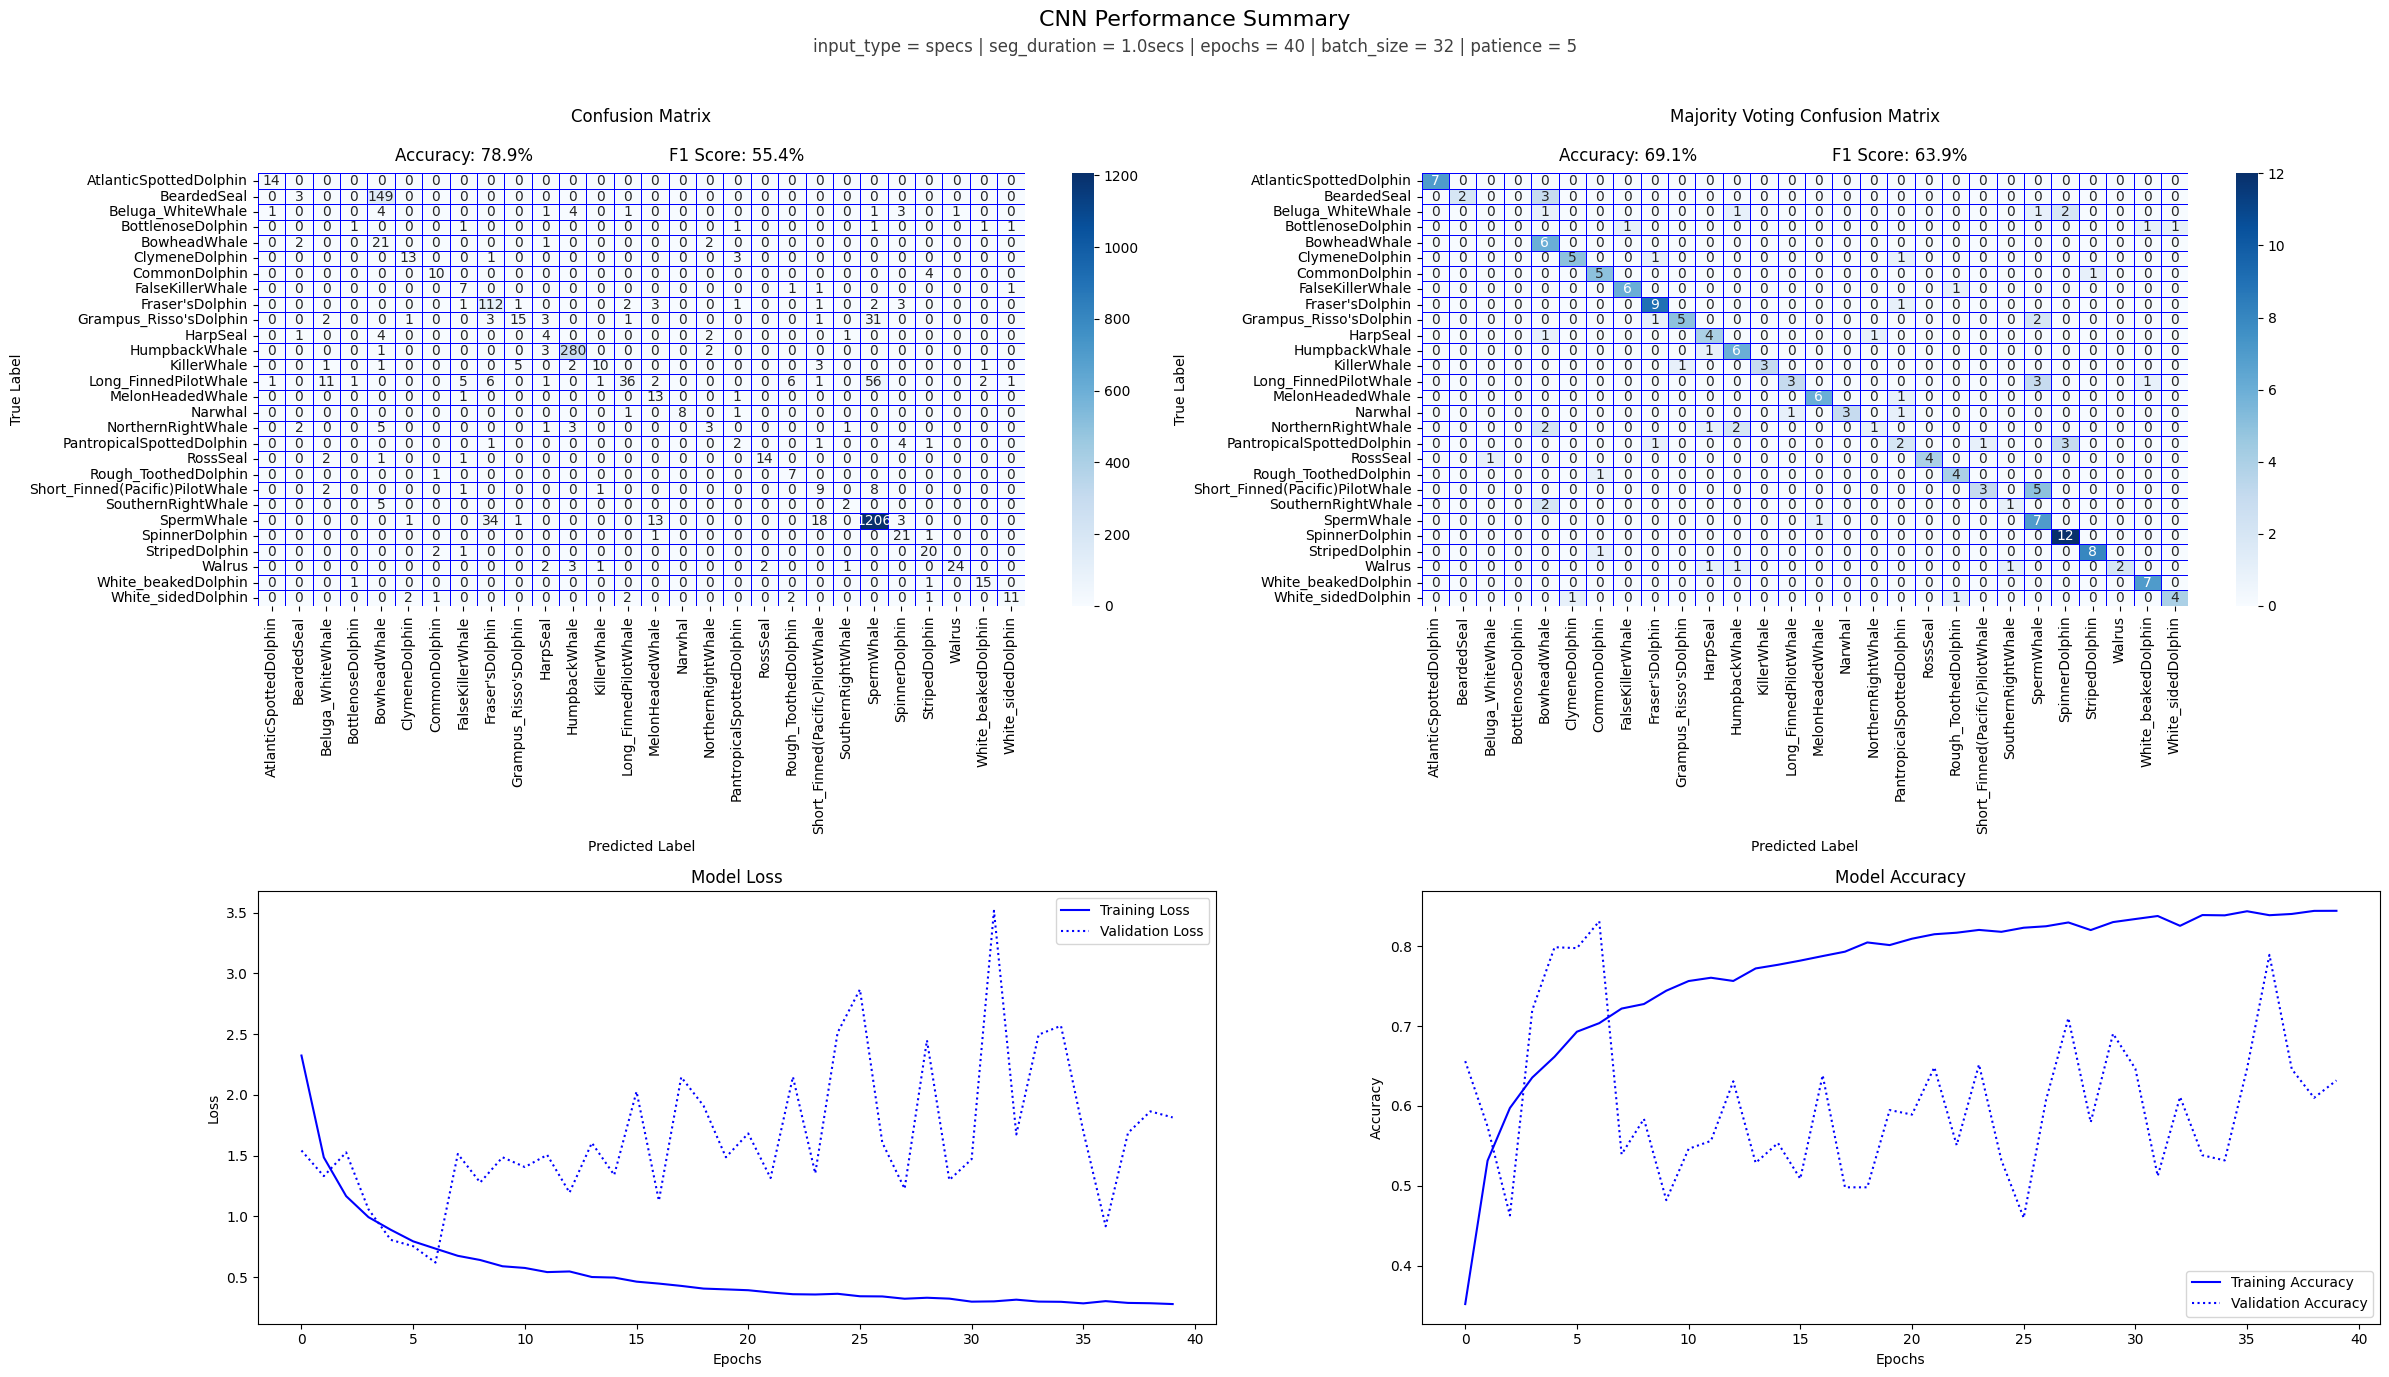

In [8]:
process_pipeline('specs_1.0_40_32_x', 'specs', '1.0', 40, 32)

Epoch 1/40
171/171 [==============================] - 12s 53ms/step - loss: 2.5766 - accuracy: 0.3085 - val_loss: 1.4617 - val_accuracy: 0.7188
Epoch 2/40
171/171 [==============================] - 8s 45ms/step - loss: 1.6781 - accuracy: 0.4953 - val_loss: 1.2590 - val_accuracy: 0.7540
Epoch 3/40
171/171 [==============================] - 8s 48ms/step - loss: 1.2179 - accuracy: 0.5974 - val_loss: 0.8759 - val_accuracy: 0.8122
Epoch 4/40
171/171 [==============================] - 8s 44ms/step - loss: 0.9342 - accuracy: 0.6629 - val_loss: 1.0864 - val_accuracy: 0.6354
Epoch 5/40
171/171 [==============================] - 8s 46ms/step - loss: 0.8105 - accuracy: 0.6943 - val_loss: 0.6465 - val_accuracy: 0.8351
Epoch 6/40
171/171 [==============================] - 7s 44ms/step - loss: 0.6969 - accuracy: 0.7190 - val_loss: 0.7713 - val_accuracy: 0.7689
Epoch 7/40
171/171 [==============================] - 8s 46ms/step - loss: 0.6061 - accuracy: 0.7468 - val_loss: 0.6338 - val_accuracy: 0.779

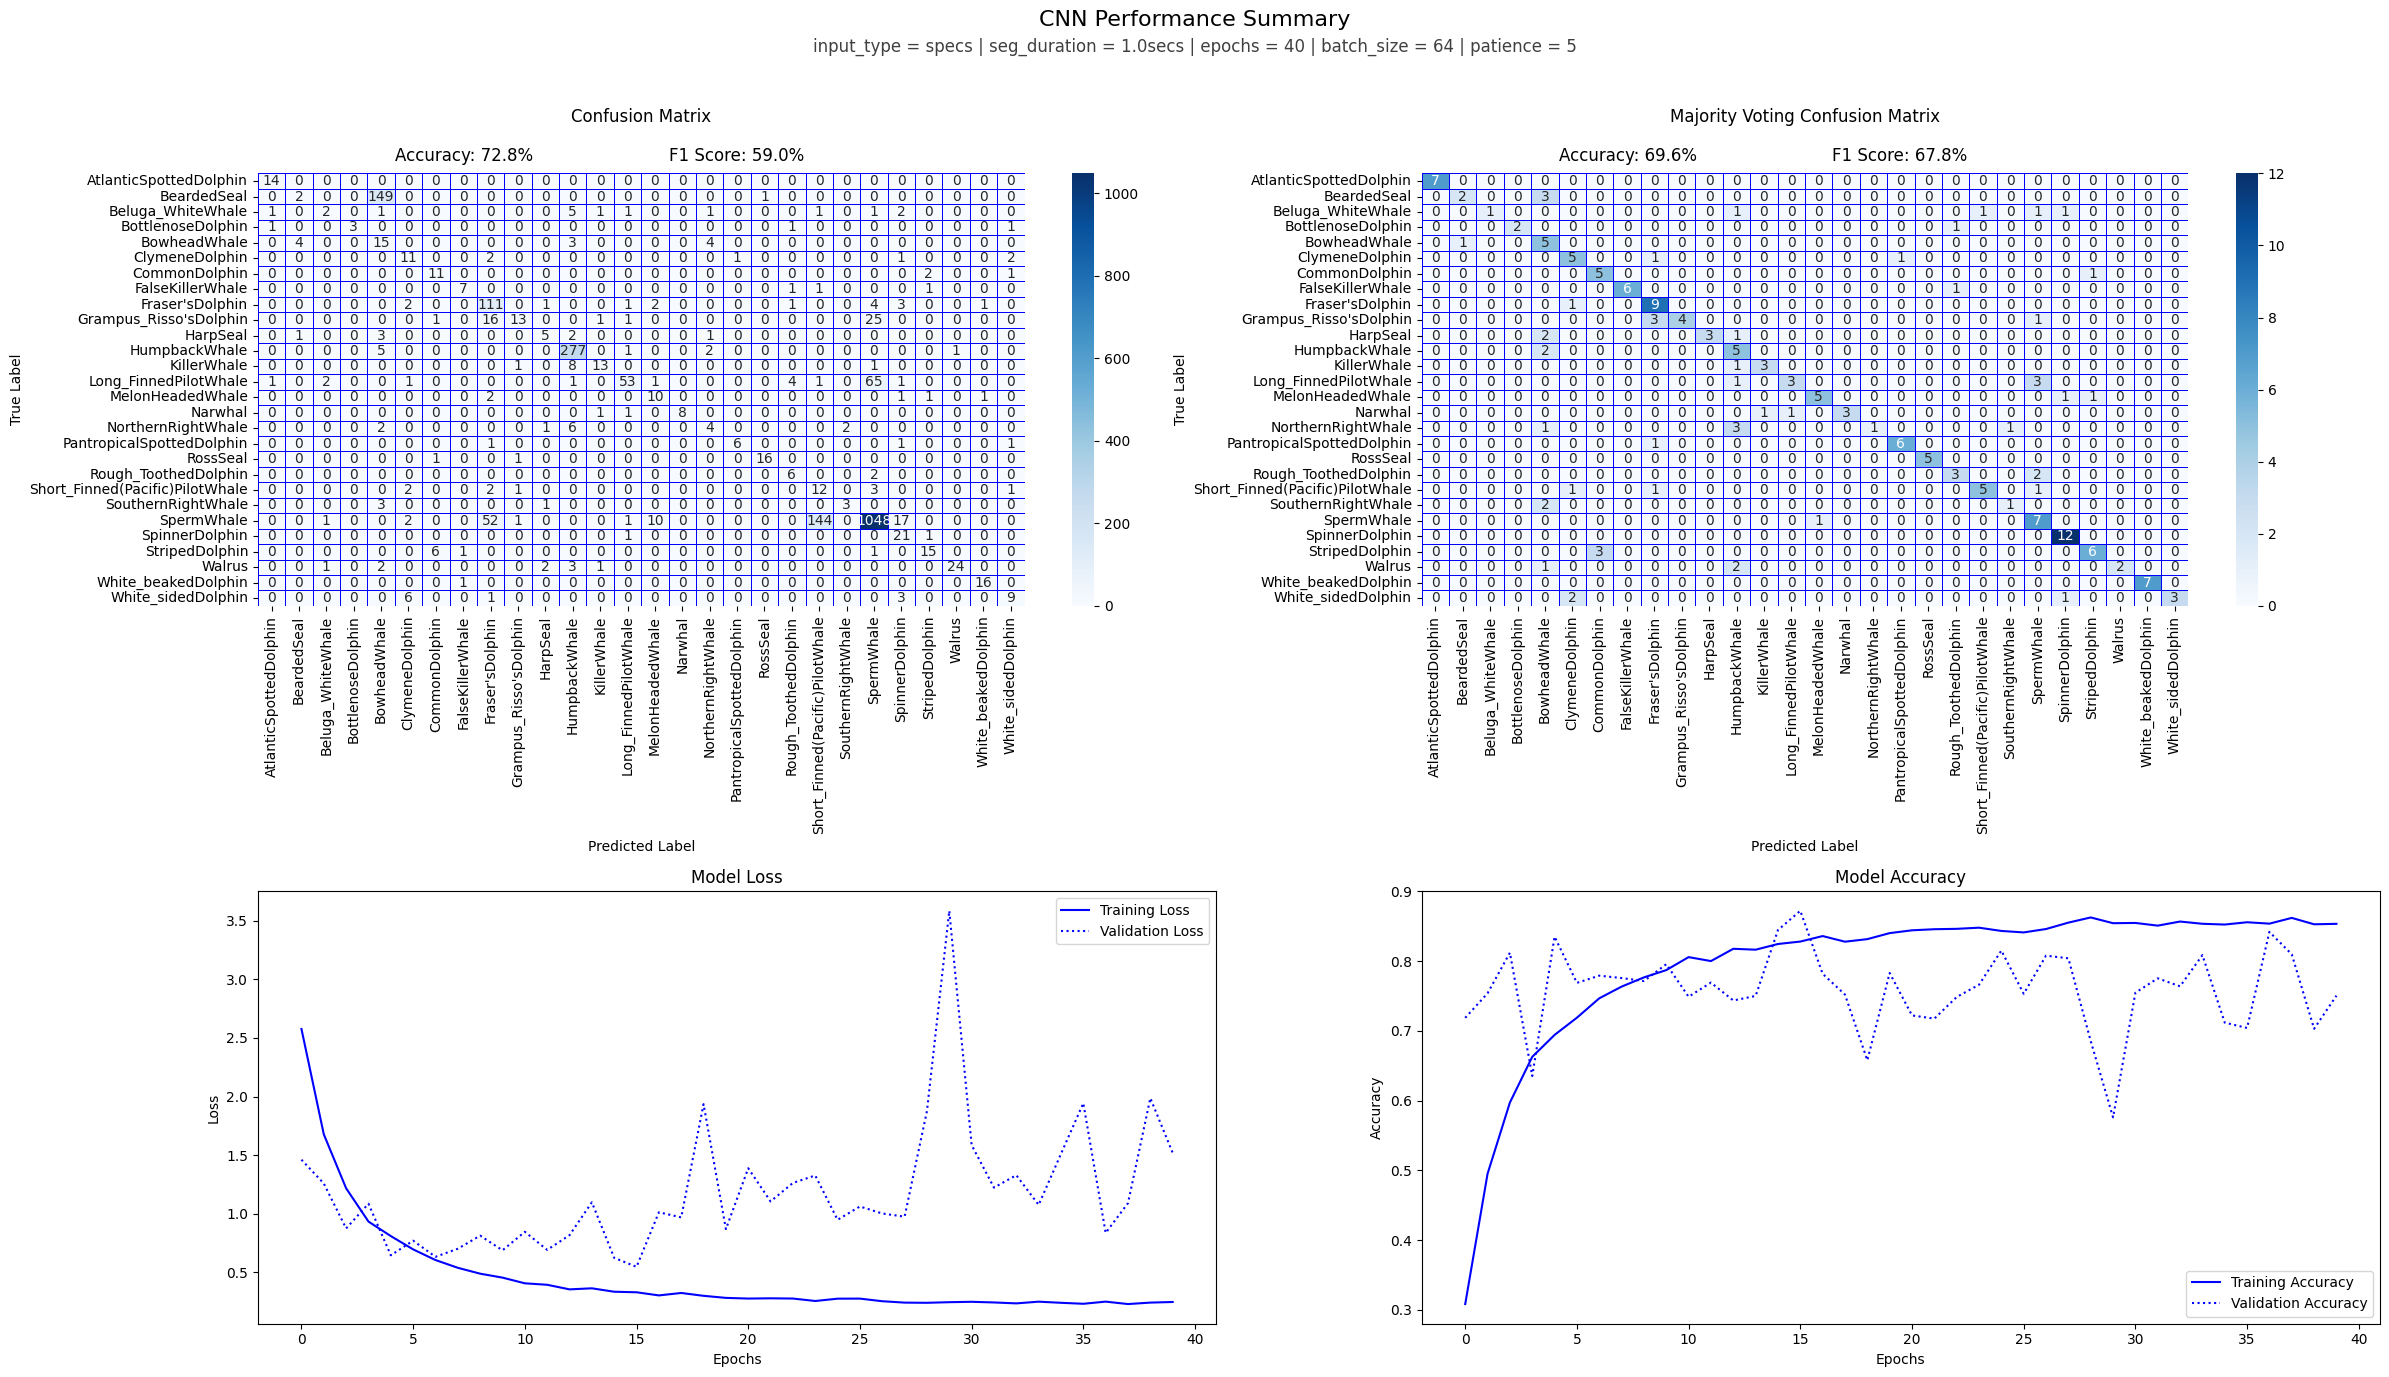

In [9]:
process_pipeline('specs_1.0_40_64_x', 'specs', '1.0', 40, 64)

Epoch 1/40
341/341 [==============================] - 11s 27ms/step - loss: 2.1216 - accuracy: 0.4097 - val_loss: 1.4186 - val_accuracy: 0.6033
Epoch 2/40
341/341 [==============================] - 9s 26ms/step - loss: 1.2849 - accuracy: 0.5679 - val_loss: 1.2954 - val_accuracy: 0.5601
Epoch 3/40
341/341 [==============================] - 9s 25ms/step - loss: 1.0353 - accuracy: 0.6307 - val_loss: 1.4257 - val_accuracy: 0.5696
Epoch 4/40
341/341 [==============================] - 8s 24ms/step - loss: 0.8644 - accuracy: 0.6703 - val_loss: 1.3711 - val_accuracy: 0.5643
Epoch 5/40
341/341 [==============================] - 9s 25ms/step - loss: 0.7575 - accuracy: 0.7008 - val_loss: 1.1370 - val_accuracy: 0.6576
Epoch 6/40
341/341 [==============================] - 8s 24ms/step - loss: 0.6685 - accuracy: 0.7229 - val_loss: 1.2560 - val_accuracy: 0.6454
Epoch 7/40
341/341 [==============================] - 8s 25ms/step - loss: 0.6000 - accuracy: 0.7400 - val_loss: 1.3826 - val_accuracy: 0.595

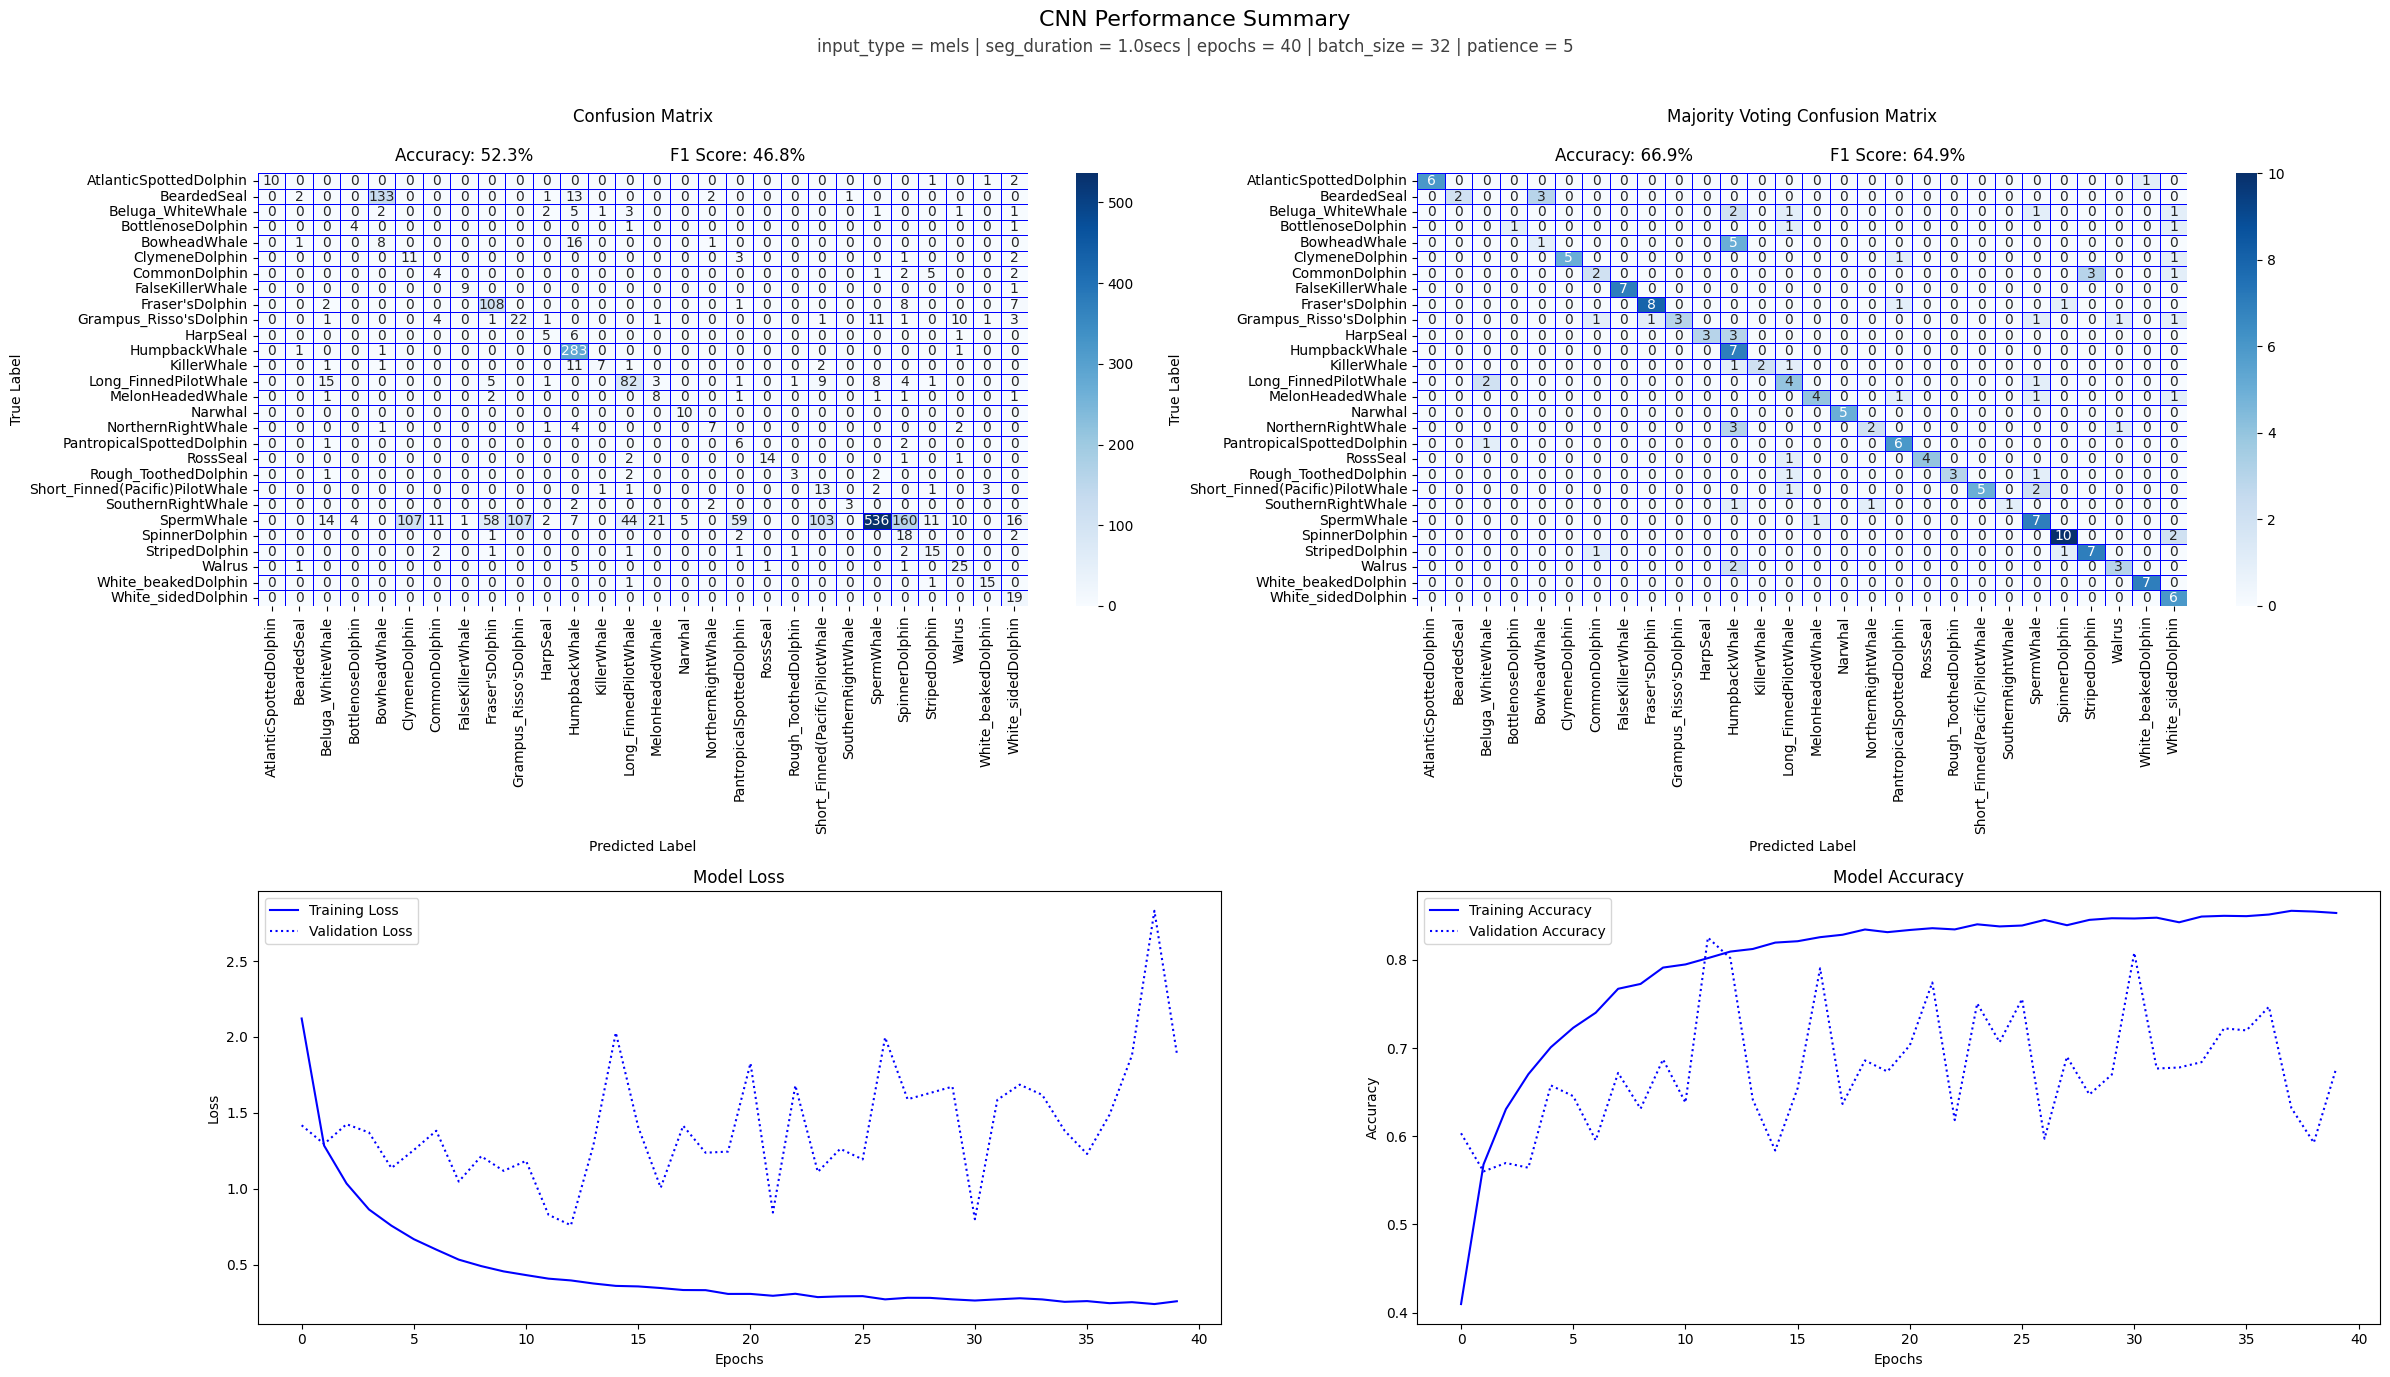

In [10]:
process_pipeline('mels_1.0_40_32_x', 'mels', '1.0', 40, 32)

Epoch 1/40
171/171 [==============================] - 10s 50ms/step - loss: 2.4966 - accuracy: 0.3774 - val_loss: 1.3576 - val_accuracy: 0.7624
Epoch 2/40
171/171 [==============================] - 8s 46ms/step - loss: 1.3988 - accuracy: 0.5615 - val_loss: 1.3056 - val_accuracy: 0.6377
Epoch 3/40
171/171 [==============================] - 8s 45ms/step - loss: 1.0627 - accuracy: 0.6331 - val_loss: 0.8615 - val_accuracy: 0.7923
Epoch 4/40
171/171 [==============================] - 8s 46ms/step - loss: 0.8772 - accuracy: 0.6740 - val_loss: 0.6370 - val_accuracy: 0.8080
Epoch 5/40
171/171 [==============================] - 7s 44ms/step - loss: 0.7224 - accuracy: 0.7136 - val_loss: 1.0036 - val_accuracy: 0.6576
Epoch 6/40
171/171 [==============================] - 8s 45ms/step - loss: 0.6298 - accuracy: 0.7410 - val_loss: 0.5568 - val_accuracy: 0.8416
Epoch 7/40
171/171 [==============================] - 8s 44ms/step - loss: 0.5598 - accuracy: 0.7613 - val_loss: 1.9619 - val_accuracy: 0.558

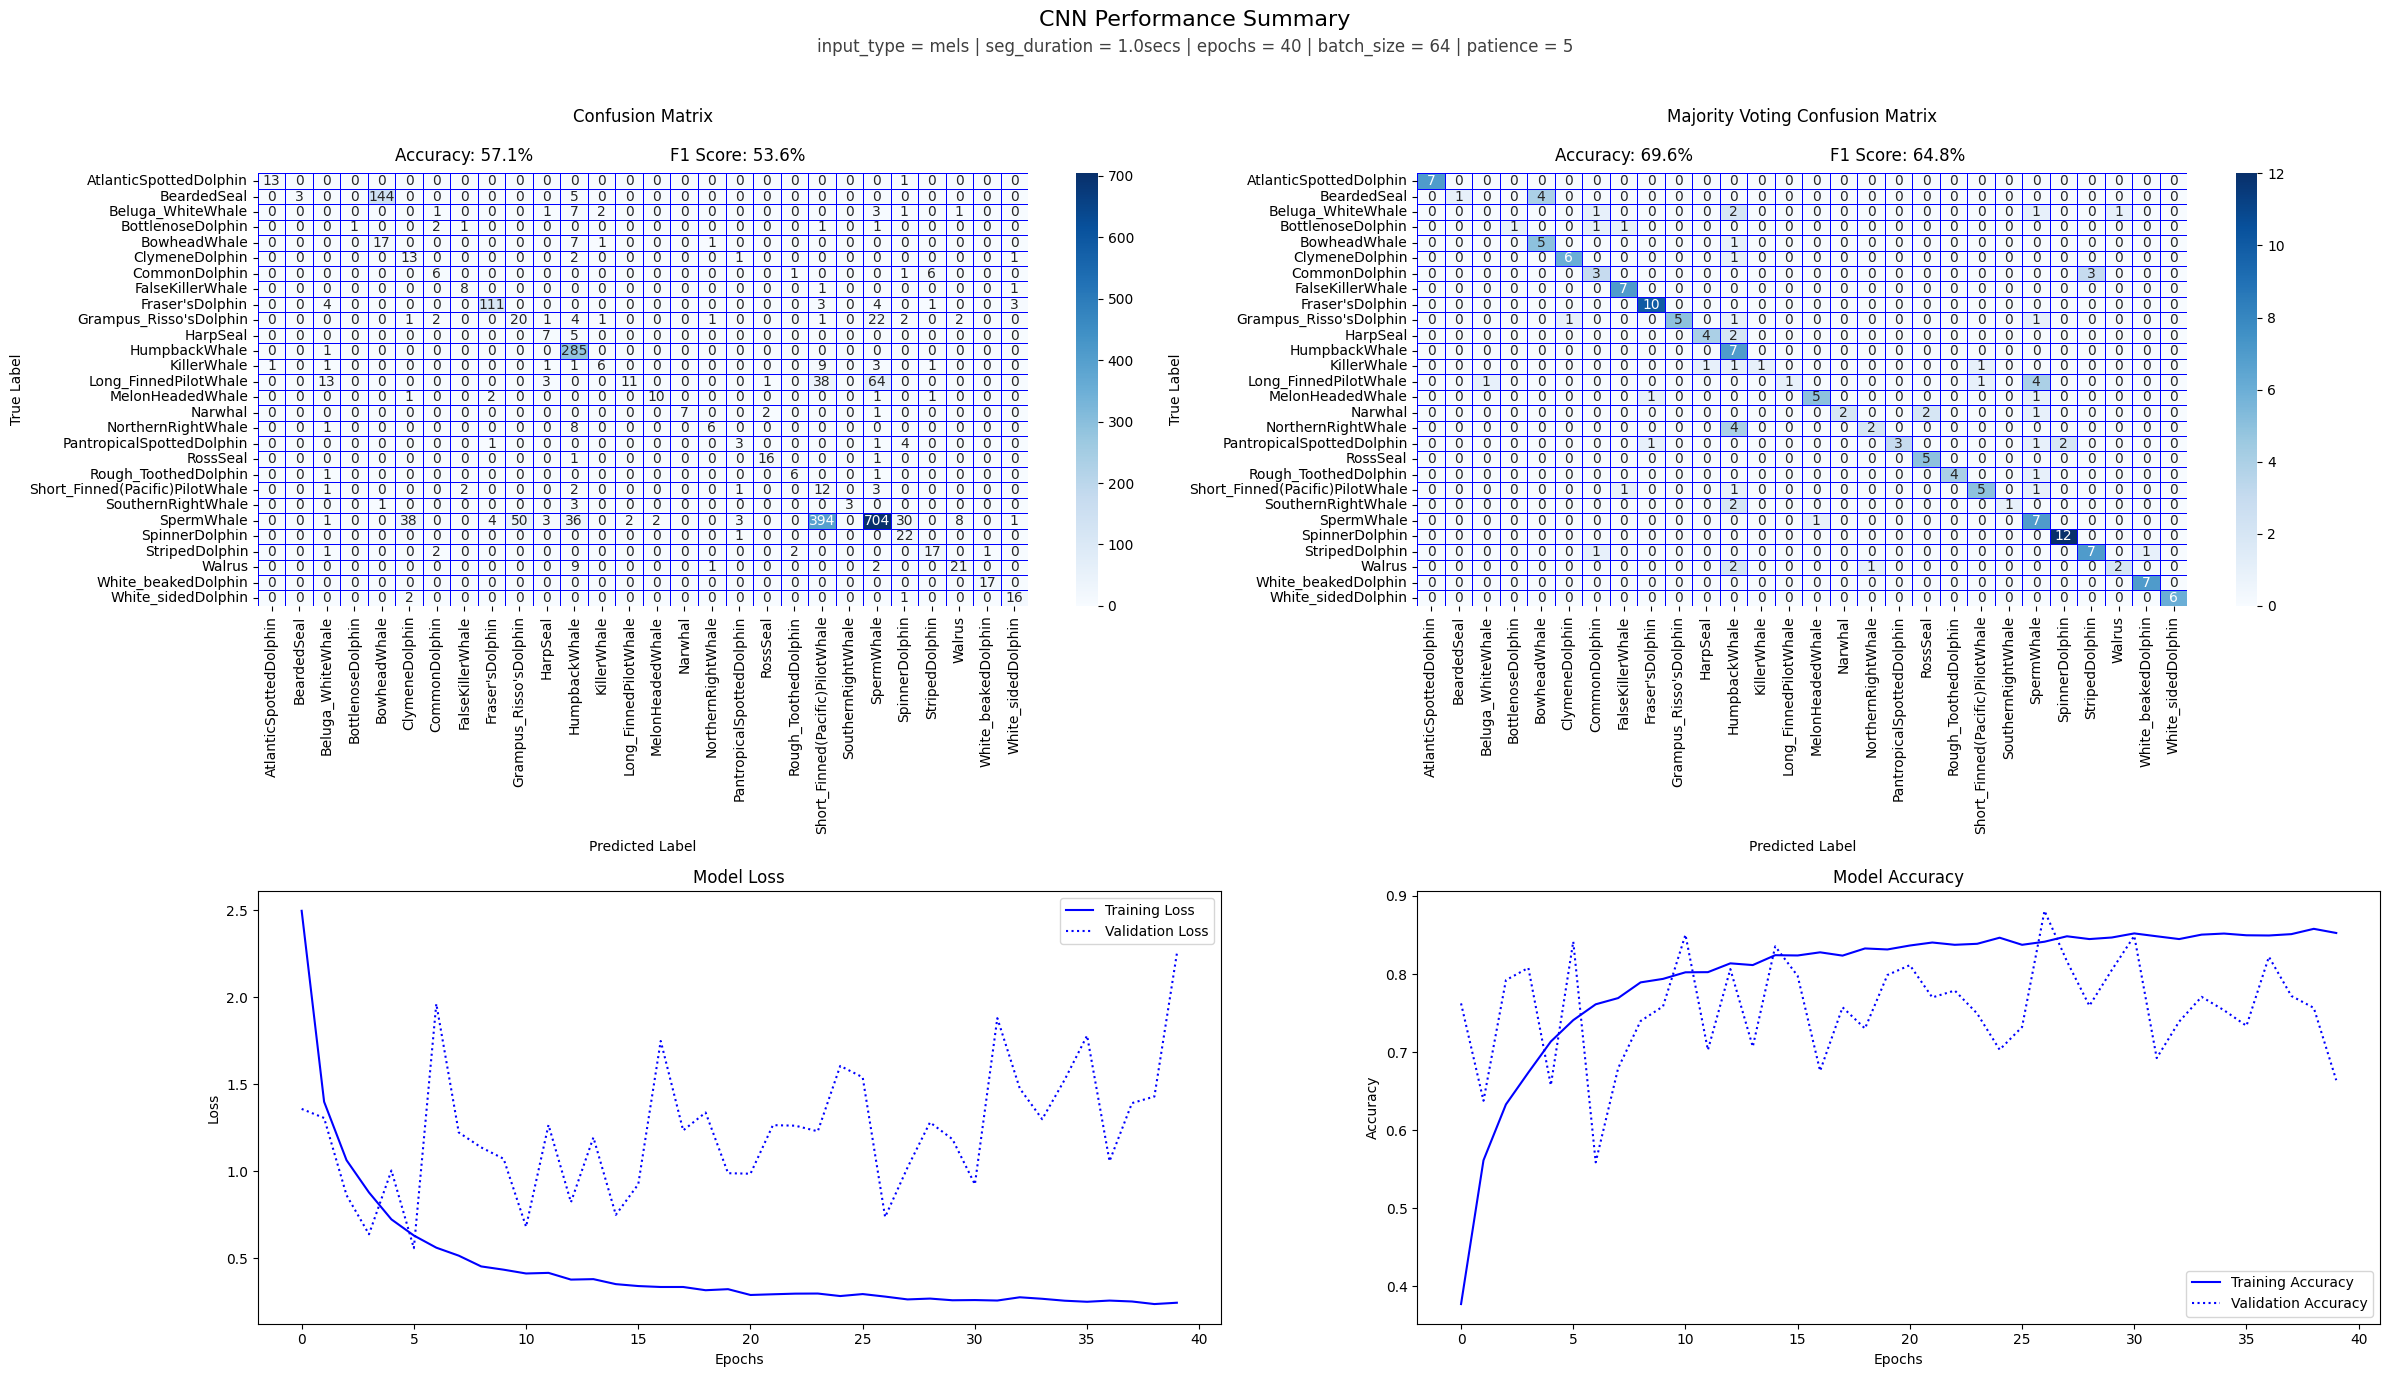

In [11]:
process_pipeline('mels_1.0_40_64_x', 'mels', '1.0', 40, 64)

Epoch 1/40
180/180 [==============================] - 7s 30ms/step - loss: 2.7509 - accuracy: 0.2610 - val_loss: 1.7334 - val_accuracy: 0.6510
Epoch 2/40
180/180 [==============================] - 4s 24ms/step - loss: 2.0506 - accuracy: 0.4056 - val_loss: 1.2704 - val_accuracy: 0.7504
Epoch 3/40
180/180 [==============================] - 4s 25ms/step - loss: 1.6815 - accuracy: 0.4678 - val_loss: 1.3434 - val_accuracy: 0.6712
Epoch 4/40
180/180 [==============================] - 4s 24ms/step - loss: 1.3951 - accuracy: 0.5448 - val_loss: 1.1597 - val_accuracy: 0.7773
Epoch 5/40
180/180 [==============================] - 4s 24ms/step - loss: 1.2239 - accuracy: 0.5812 - val_loss: 1.0926 - val_accuracy: 0.7848
Epoch 6/40
180/180 [==============================] - 4s 25ms/step - loss: 1.0567 - accuracy: 0.6230 - val_loss: 1.4733 - val_accuracy: 0.5717
Epoch 7/40
180/180 [==============================] - 4s 24ms/step - loss: 0.9668 - accuracy: 0.6432 - val_loss: 1.0258 - val_accuracy: 0.7205

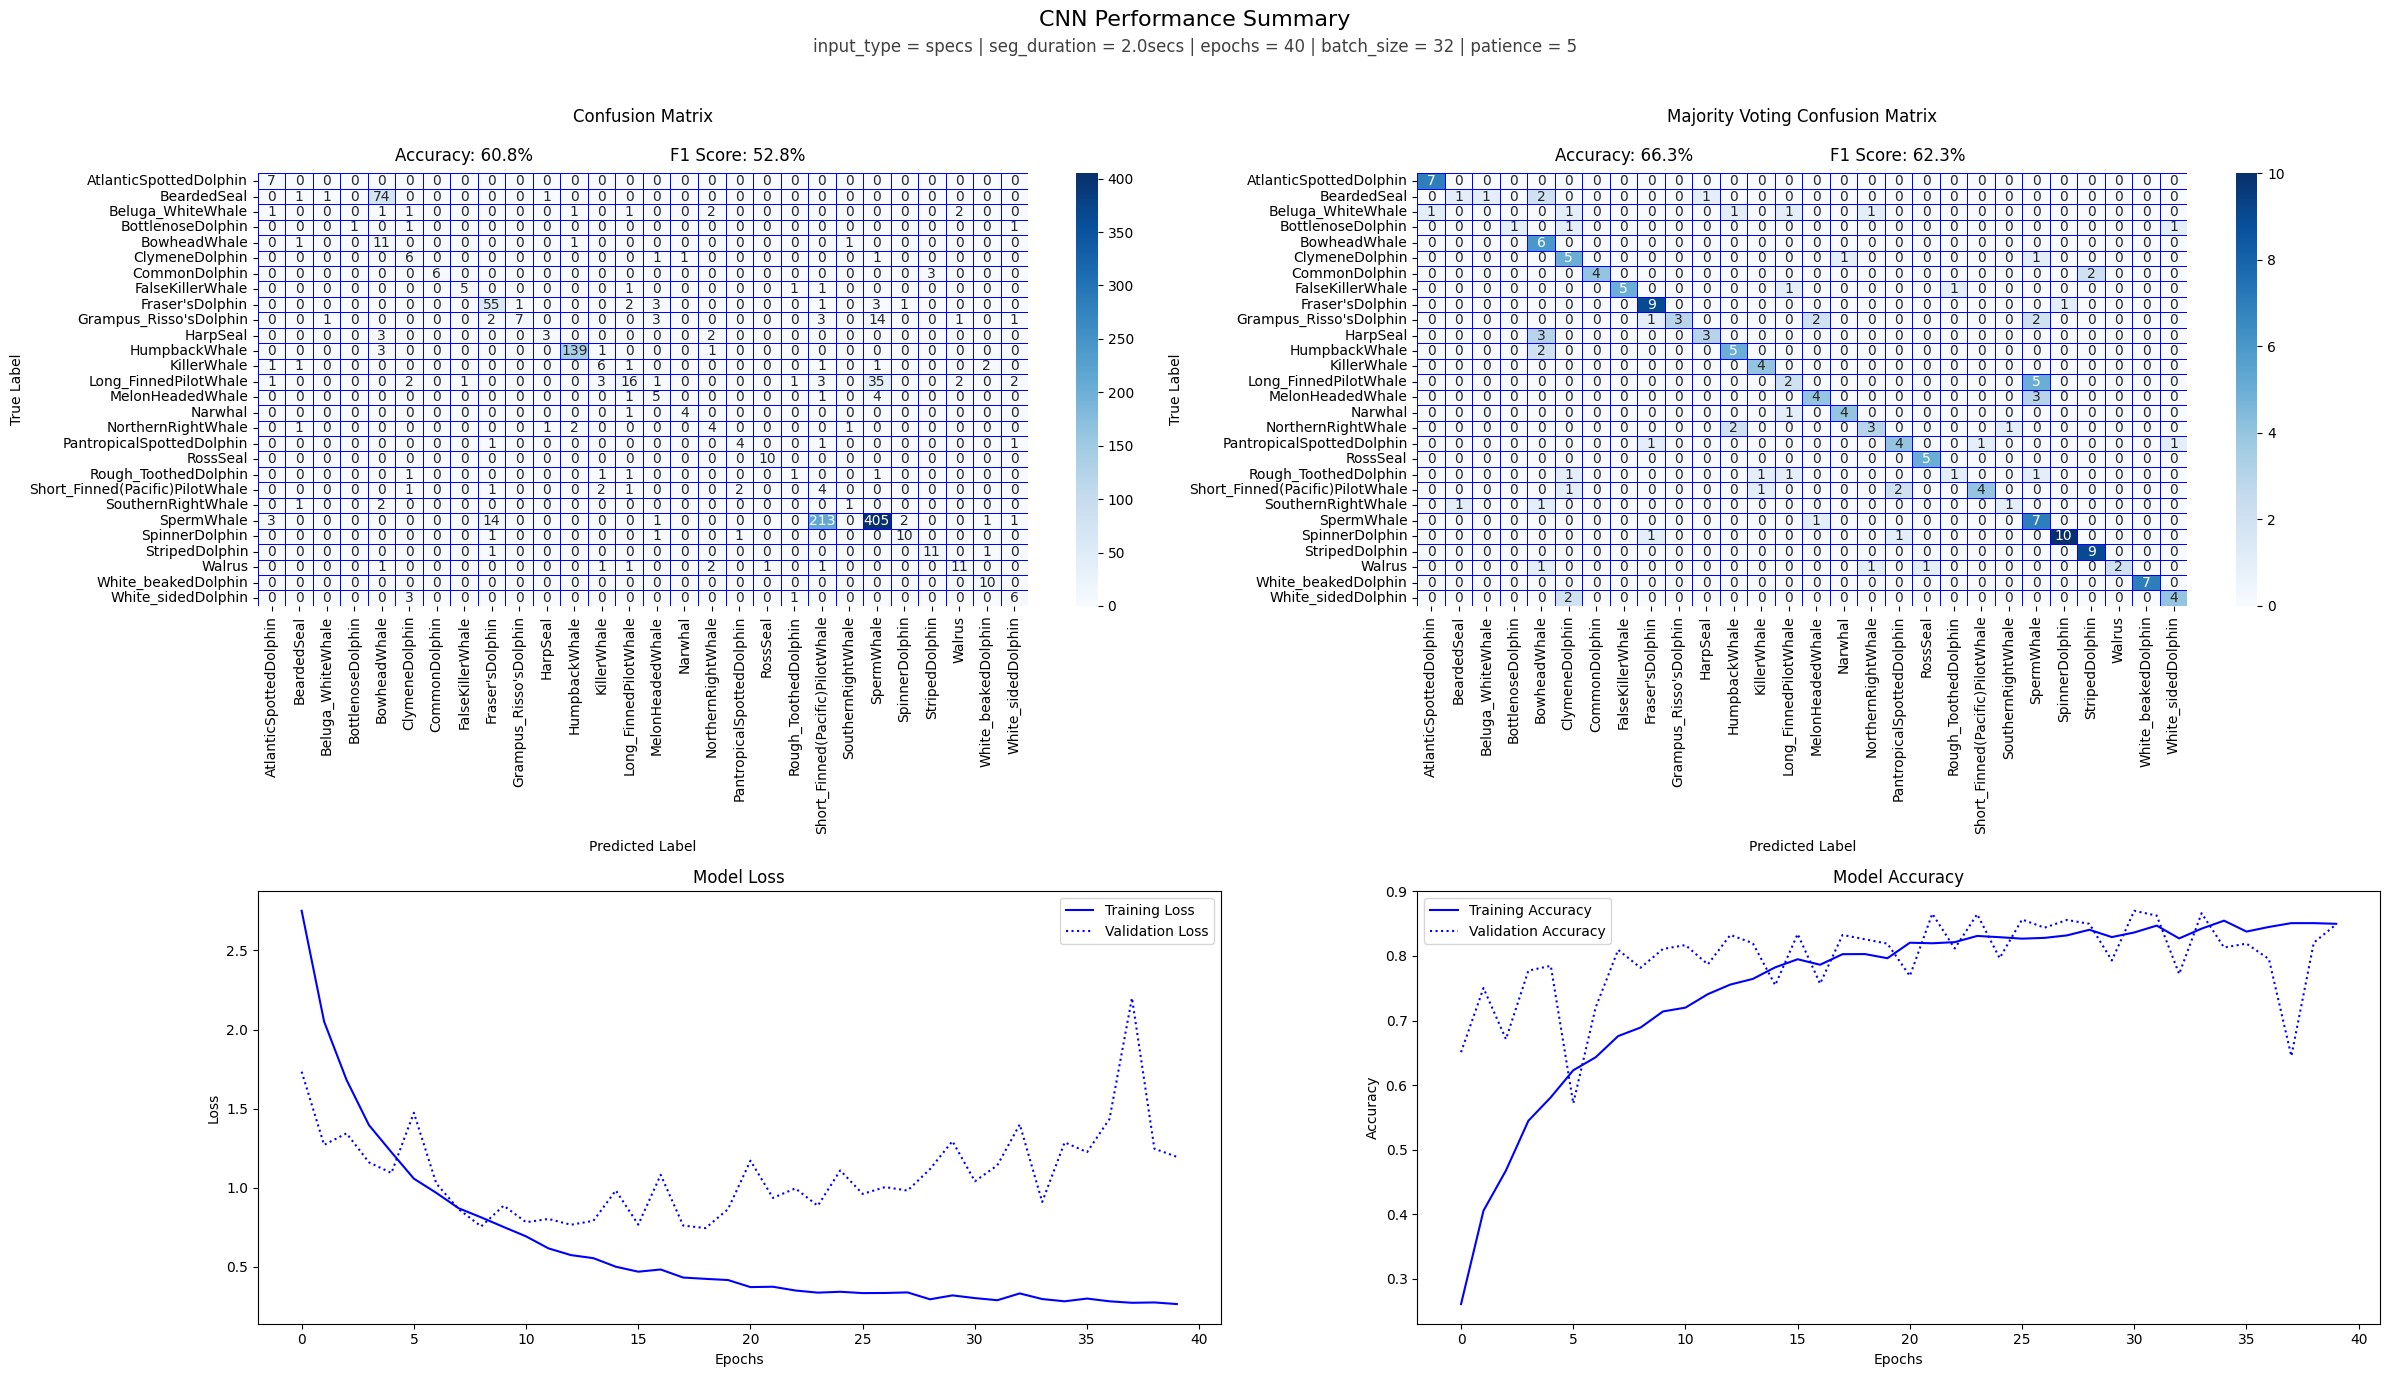

In [12]:
process_pipeline('specs_2.0_40_32_x', 'specs', '2.0', 40, 32)

Epoch 1/40
90/90 [==============================] - 7s 58ms/step - loss: 2.7574 - accuracy: 0.2800 - val_loss: 2.0641 - val_accuracy: 0.4895
Epoch 2/40
90/90 [==============================] - 4s 44ms/step - loss: 1.9588 - accuracy: 0.4359 - val_loss: 1.2287 - val_accuracy: 0.7280
Epoch 3/40
90/90 [==============================] - 4s 46ms/step - loss: 1.5322 - accuracy: 0.5132 - val_loss: 1.3118 - val_accuracy: 0.7190
Epoch 4/40
90/90 [==============================] - 4s 43ms/step - loss: 1.3369 - accuracy: 0.5632 - val_loss: 1.0959 - val_accuracy: 0.7205
Epoch 5/40
90/90 [==============================] - 4s 44ms/step - loss: 1.1182 - accuracy: 0.6064 - val_loss: 1.0566 - val_accuracy: 0.7578
Epoch 6/40
90/90 [==============================] - 4s 45ms/step - loss: 0.9875 - accuracy: 0.6437 - val_loss: 1.0042 - val_accuracy: 0.7691
Epoch 7/40
90/90 [==============================] - 4s 43ms/step - loss: 0.8758 - accuracy: 0.6733 - val_loss: 1.0223 - val_accuracy: 0.7556
Epoch 8/40
90

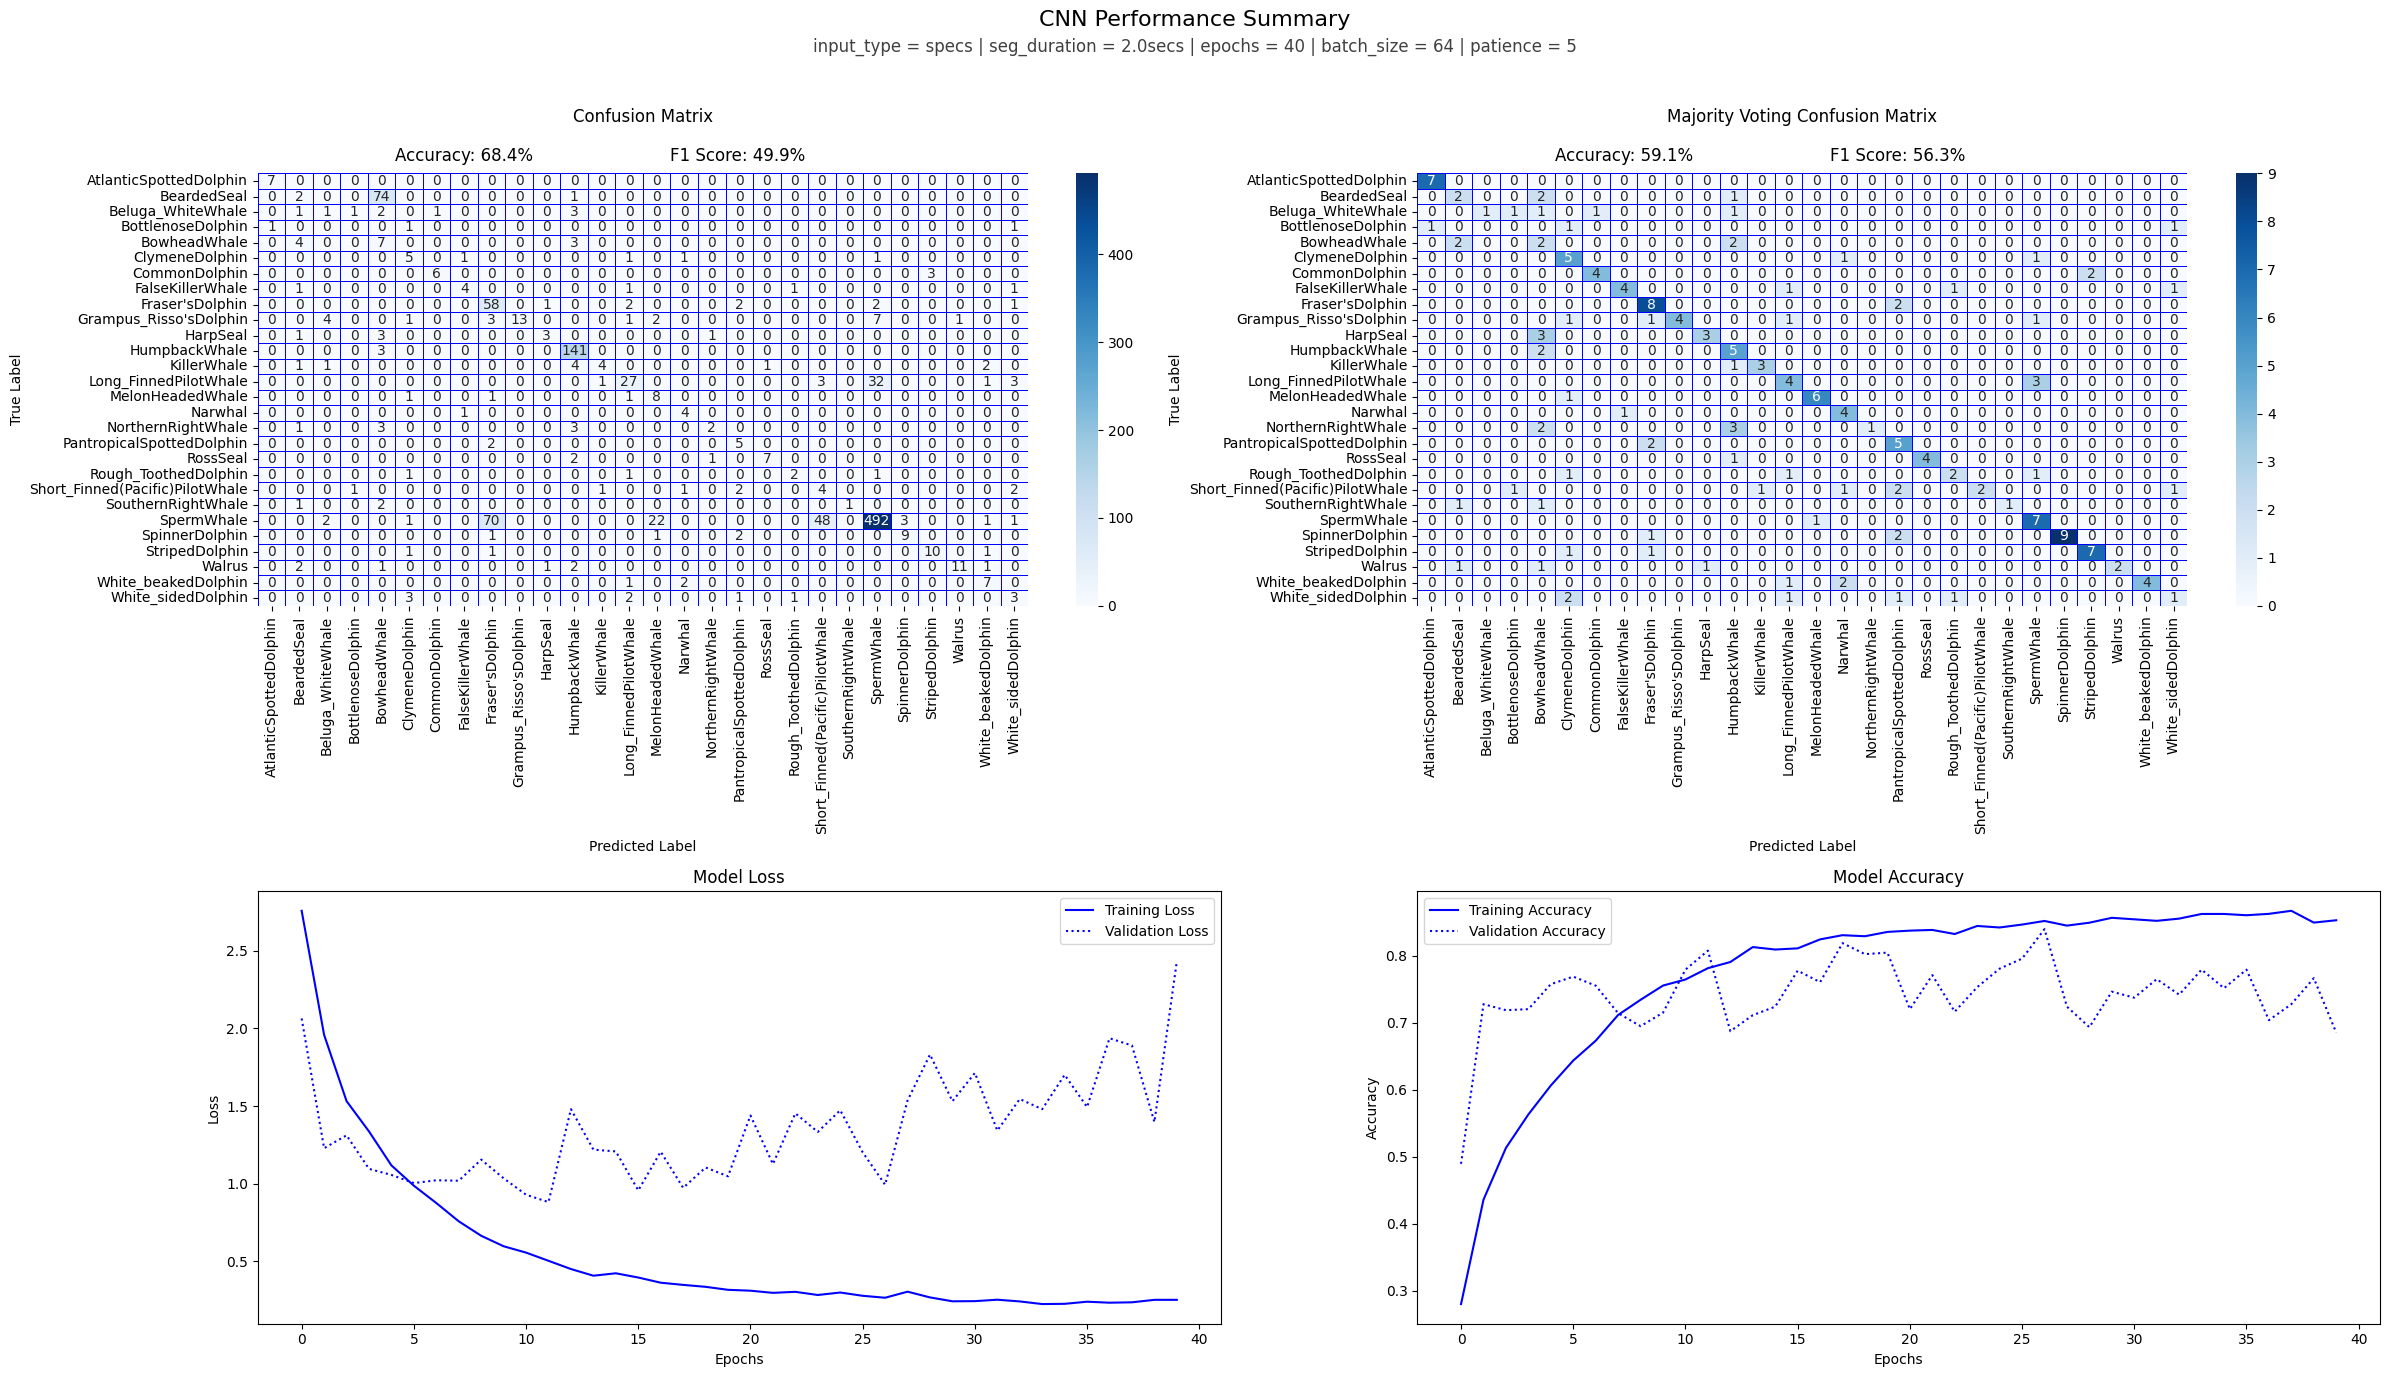

In [13]:
process_pipeline('specs_2.0_40_64_x', 'specs', '2.0', 40, 64)

Epoch 1/40
180/180 [==============================] - 7s 26ms/step - loss: 2.9617 - accuracy: 0.2969 - val_loss: 2.0287 - val_accuracy: 0.3827
Epoch 2/40
180/180 [==============================] - 4s 25ms/step - loss: 1.7560 - accuracy: 0.4812 - val_loss: 1.3809 - val_accuracy: 0.6143
Epoch 3/40
180/180 [==============================] - 5s 26ms/step - loss: 1.3338 - accuracy: 0.5659 - val_loss: 1.4170 - val_accuracy: 0.4507
Epoch 4/40
180/180 [==============================] - 4s 25ms/step - loss: 1.0747 - accuracy: 0.6267 - val_loss: 1.3491 - val_accuracy: 0.5157
Epoch 5/40
180/180 [==============================] - 4s 24ms/step - loss: 0.8940 - accuracy: 0.6812 - val_loss: 1.0515 - val_accuracy: 0.6629
Epoch 6/40
180/180 [==============================] - 5s 25ms/step - loss: 0.7668 - accuracy: 0.7024 - val_loss: 0.8831 - val_accuracy: 0.7593
Epoch 7/40
180/180 [==============================] - 5s 25ms/step - loss: 0.7056 - accuracy: 0.7296 - val_loss: 0.8431 - val_accuracy: 0.7250

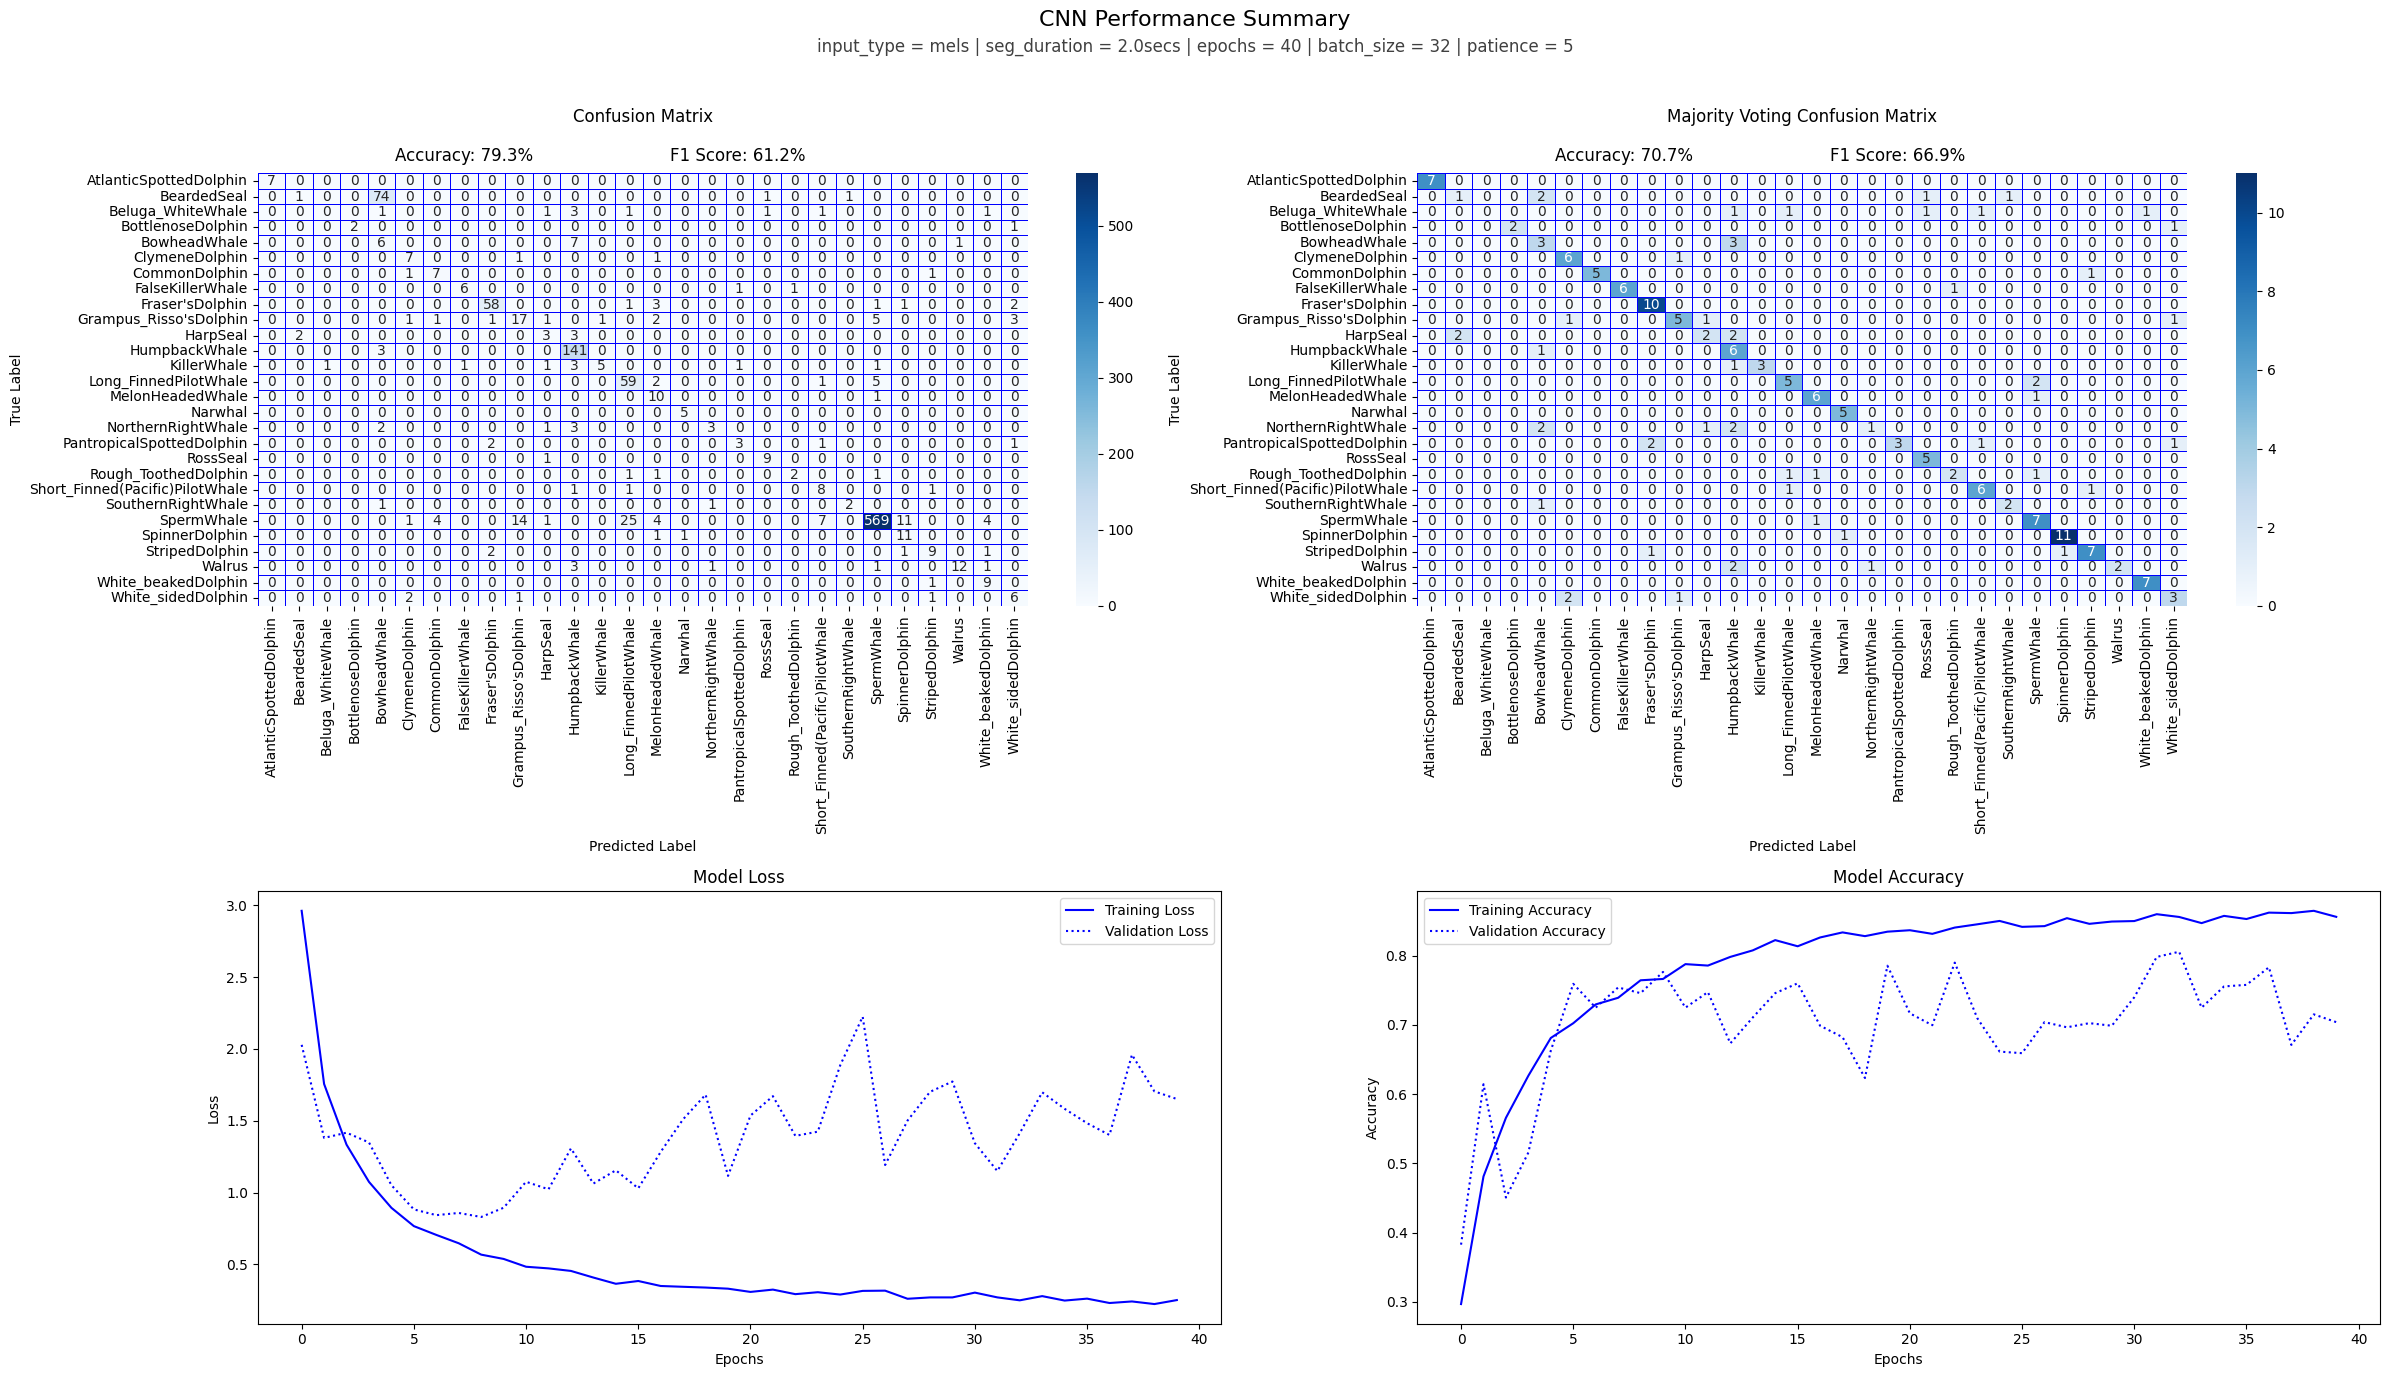

In [14]:
process_pipeline('mels_2.0_40_32_x', 'mels', '2.0', 40, 32)

Epoch 1/40
90/90 [==============================] - 6s 47ms/step - loss: 4.1277 - accuracy: 0.2789 - val_loss: 2.0954 - val_accuracy: 0.1951
Epoch 2/40
90/90 [==============================] - 4s 44ms/step - loss: 2.2829 - accuracy: 0.3688 - val_loss: 2.0318 - val_accuracy: 0.3886
Epoch 3/40
90/90 [==============================] - 4s 45ms/step - loss: 2.0372 - accuracy: 0.4155 - val_loss: 1.4738 - val_accuracy: 0.6151
Epoch 4/40
90/90 [==============================] - 4s 43ms/step - loss: 1.6532 - accuracy: 0.5030 - val_loss: 1.4383 - val_accuracy: 0.6315
Epoch 5/40
90/90 [==============================] - 4s 43ms/step - loss: 1.3372 - accuracy: 0.5659 - val_loss: 1.3734 - val_accuracy: 0.5673
Epoch 6/40
90/90 [==============================] - 4s 45ms/step - loss: 1.1363 - accuracy: 0.6118 - val_loss: 1.4140 - val_accuracy: 0.5105
Epoch 7/40
90/90 [==============================] - 4s 44ms/step - loss: 1.0229 - accuracy: 0.6448 - val_loss: 1.1729 - val_accuracy: 0.6368
Epoch 8/40
90

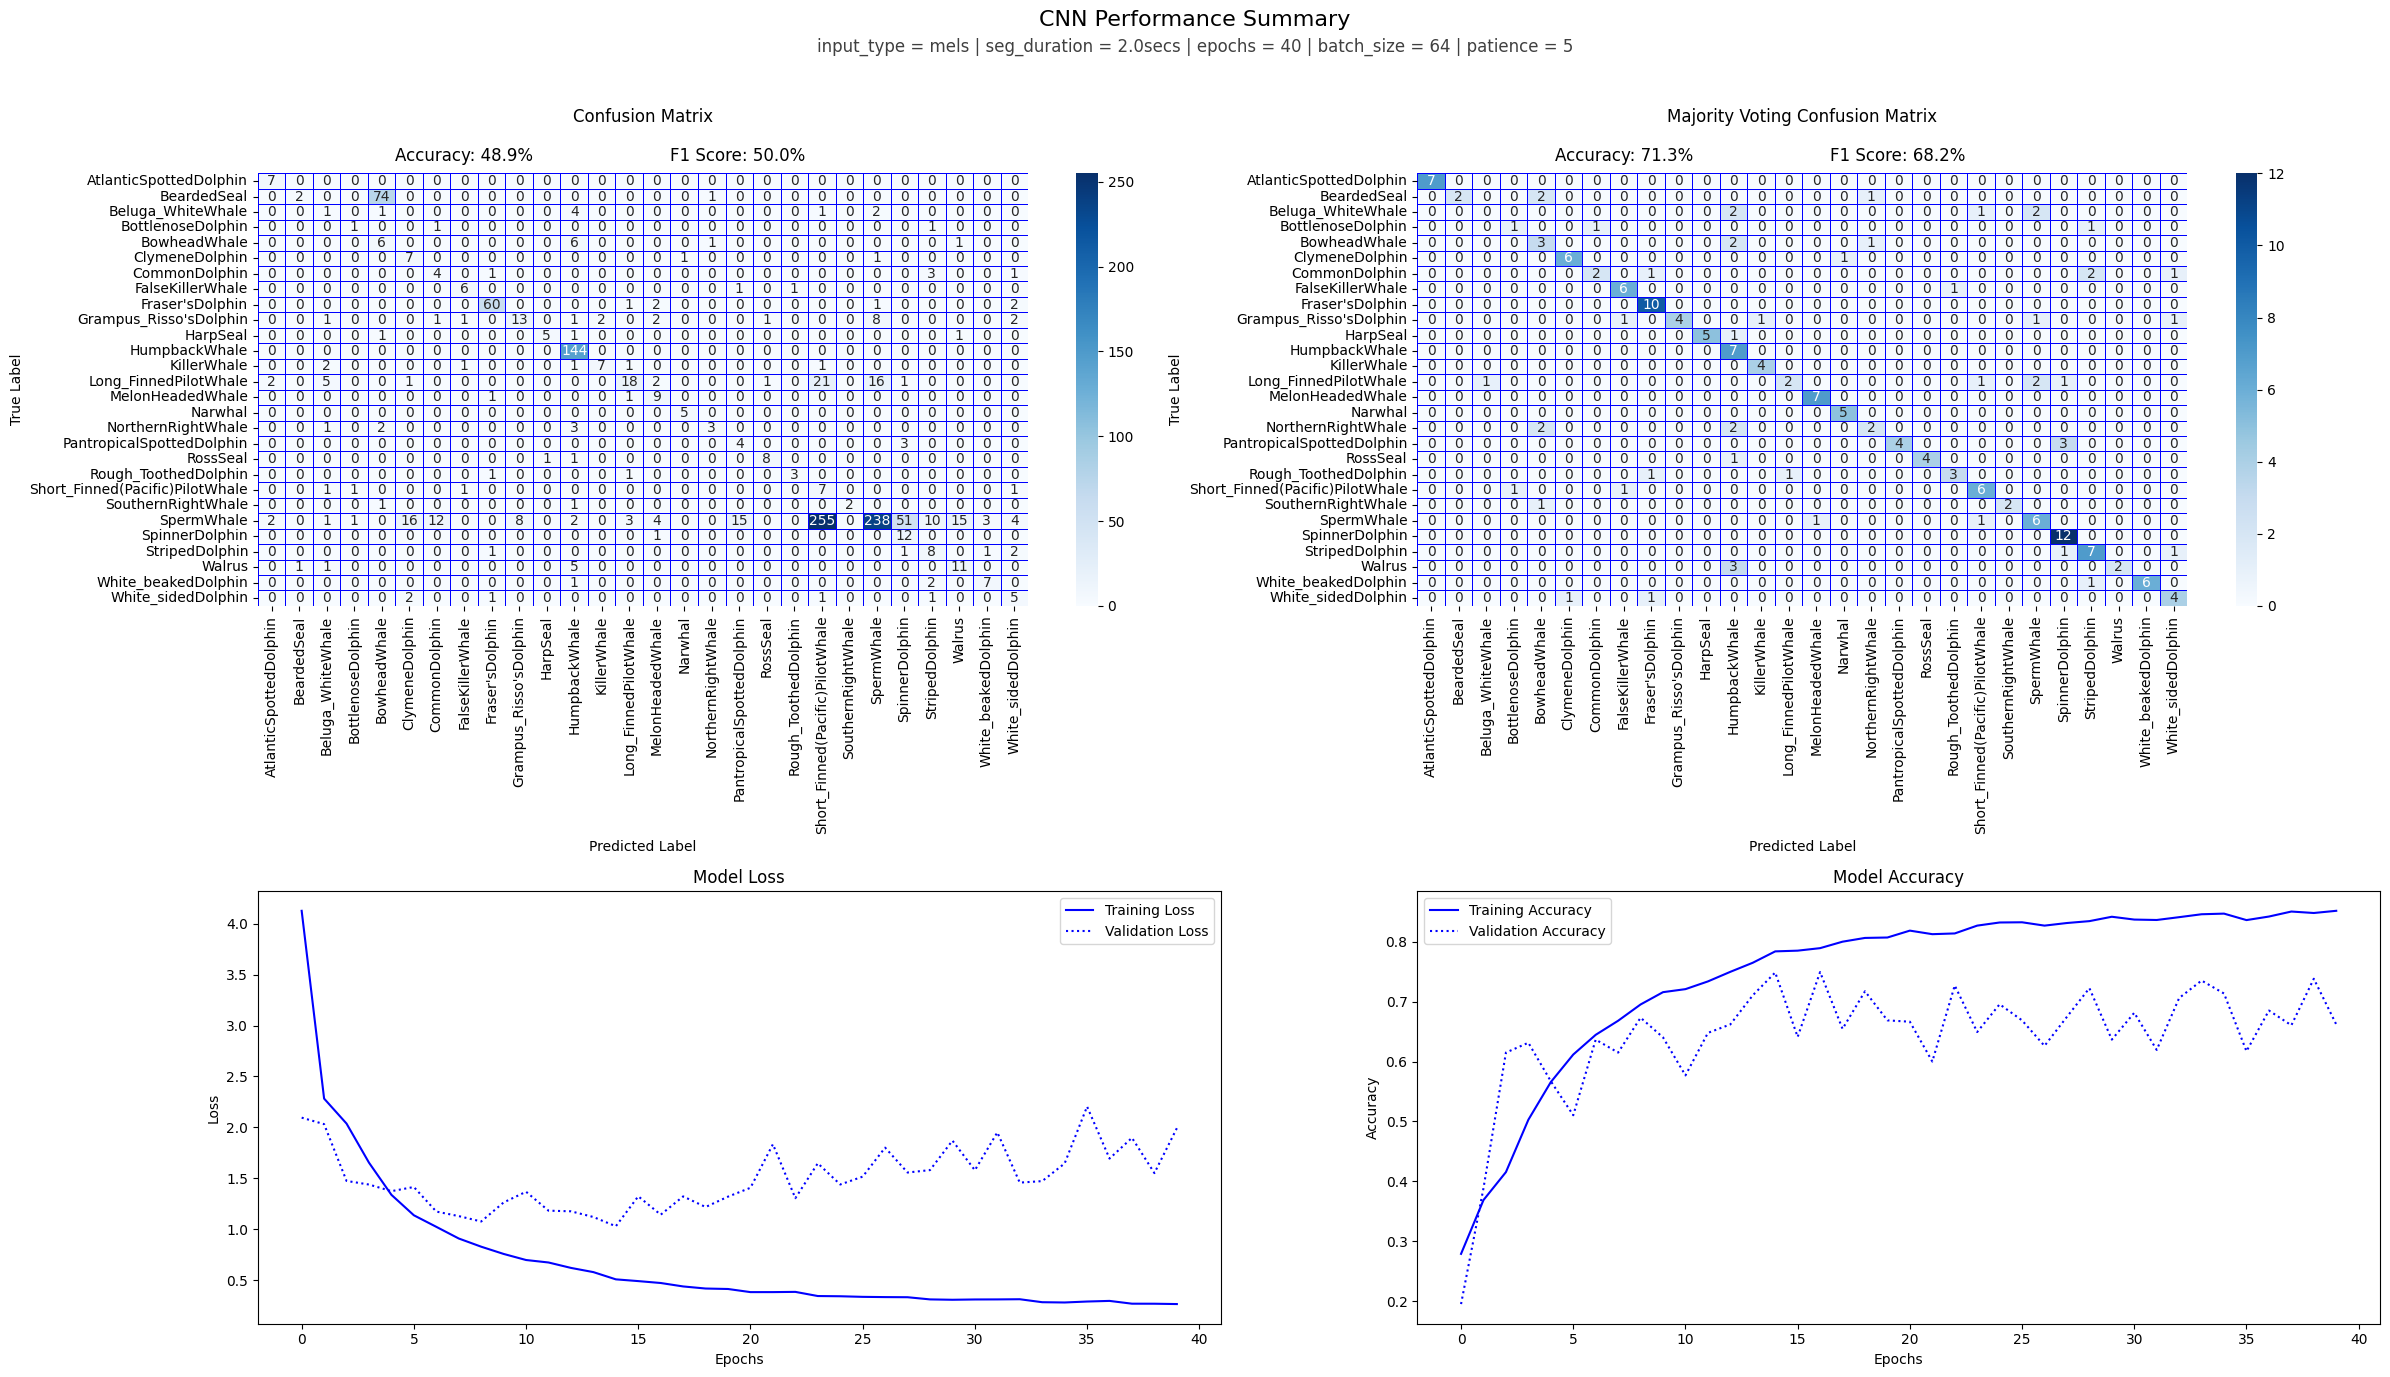

In [15]:
process_pipeline('mels_2.0_40_64_x', 'mels', '2.0', 40, 64)

Epoch 1/40
90/90 [==============================] - 5s 42ms/step - loss: 3.2680 - accuracy: 0.1804 - val_loss: 2.2121 - val_accuracy: 0.4395
Epoch 2/40
90/90 [==============================] - 2s 24ms/step - loss: 2.6576 - accuracy: 0.2211 - val_loss: 2.0042 - val_accuracy: 0.5721
Epoch 3/40
90/90 [==============================] - 2s 24ms/step - loss: 2.4300 - accuracy: 0.3111 - val_loss: 1.7345 - val_accuracy: 0.6517
Epoch 4/40
90/90 [==============================] - 2s 23ms/step - loss: 2.2437 - accuracy: 0.3452 - val_loss: 1.7052 - val_accuracy: 0.6468
Epoch 5/40
90/90 [==============================] - 2s 24ms/step - loss: 2.0659 - accuracy: 0.3830 - val_loss: 1.5894 - val_accuracy: 0.6302
Epoch 6/40
90/90 [==============================] - 2s 24ms/step - loss: 1.8981 - accuracy: 0.4147 - val_loss: 1.4018 - val_accuracy: 0.6799
Epoch 7/40
90/90 [==============================] - 2s 25ms/step - loss: 1.6956 - accuracy: 0.4699 - val_loss: 1.5430 - val_accuracy: 0.4842
Epoch 8/40
90

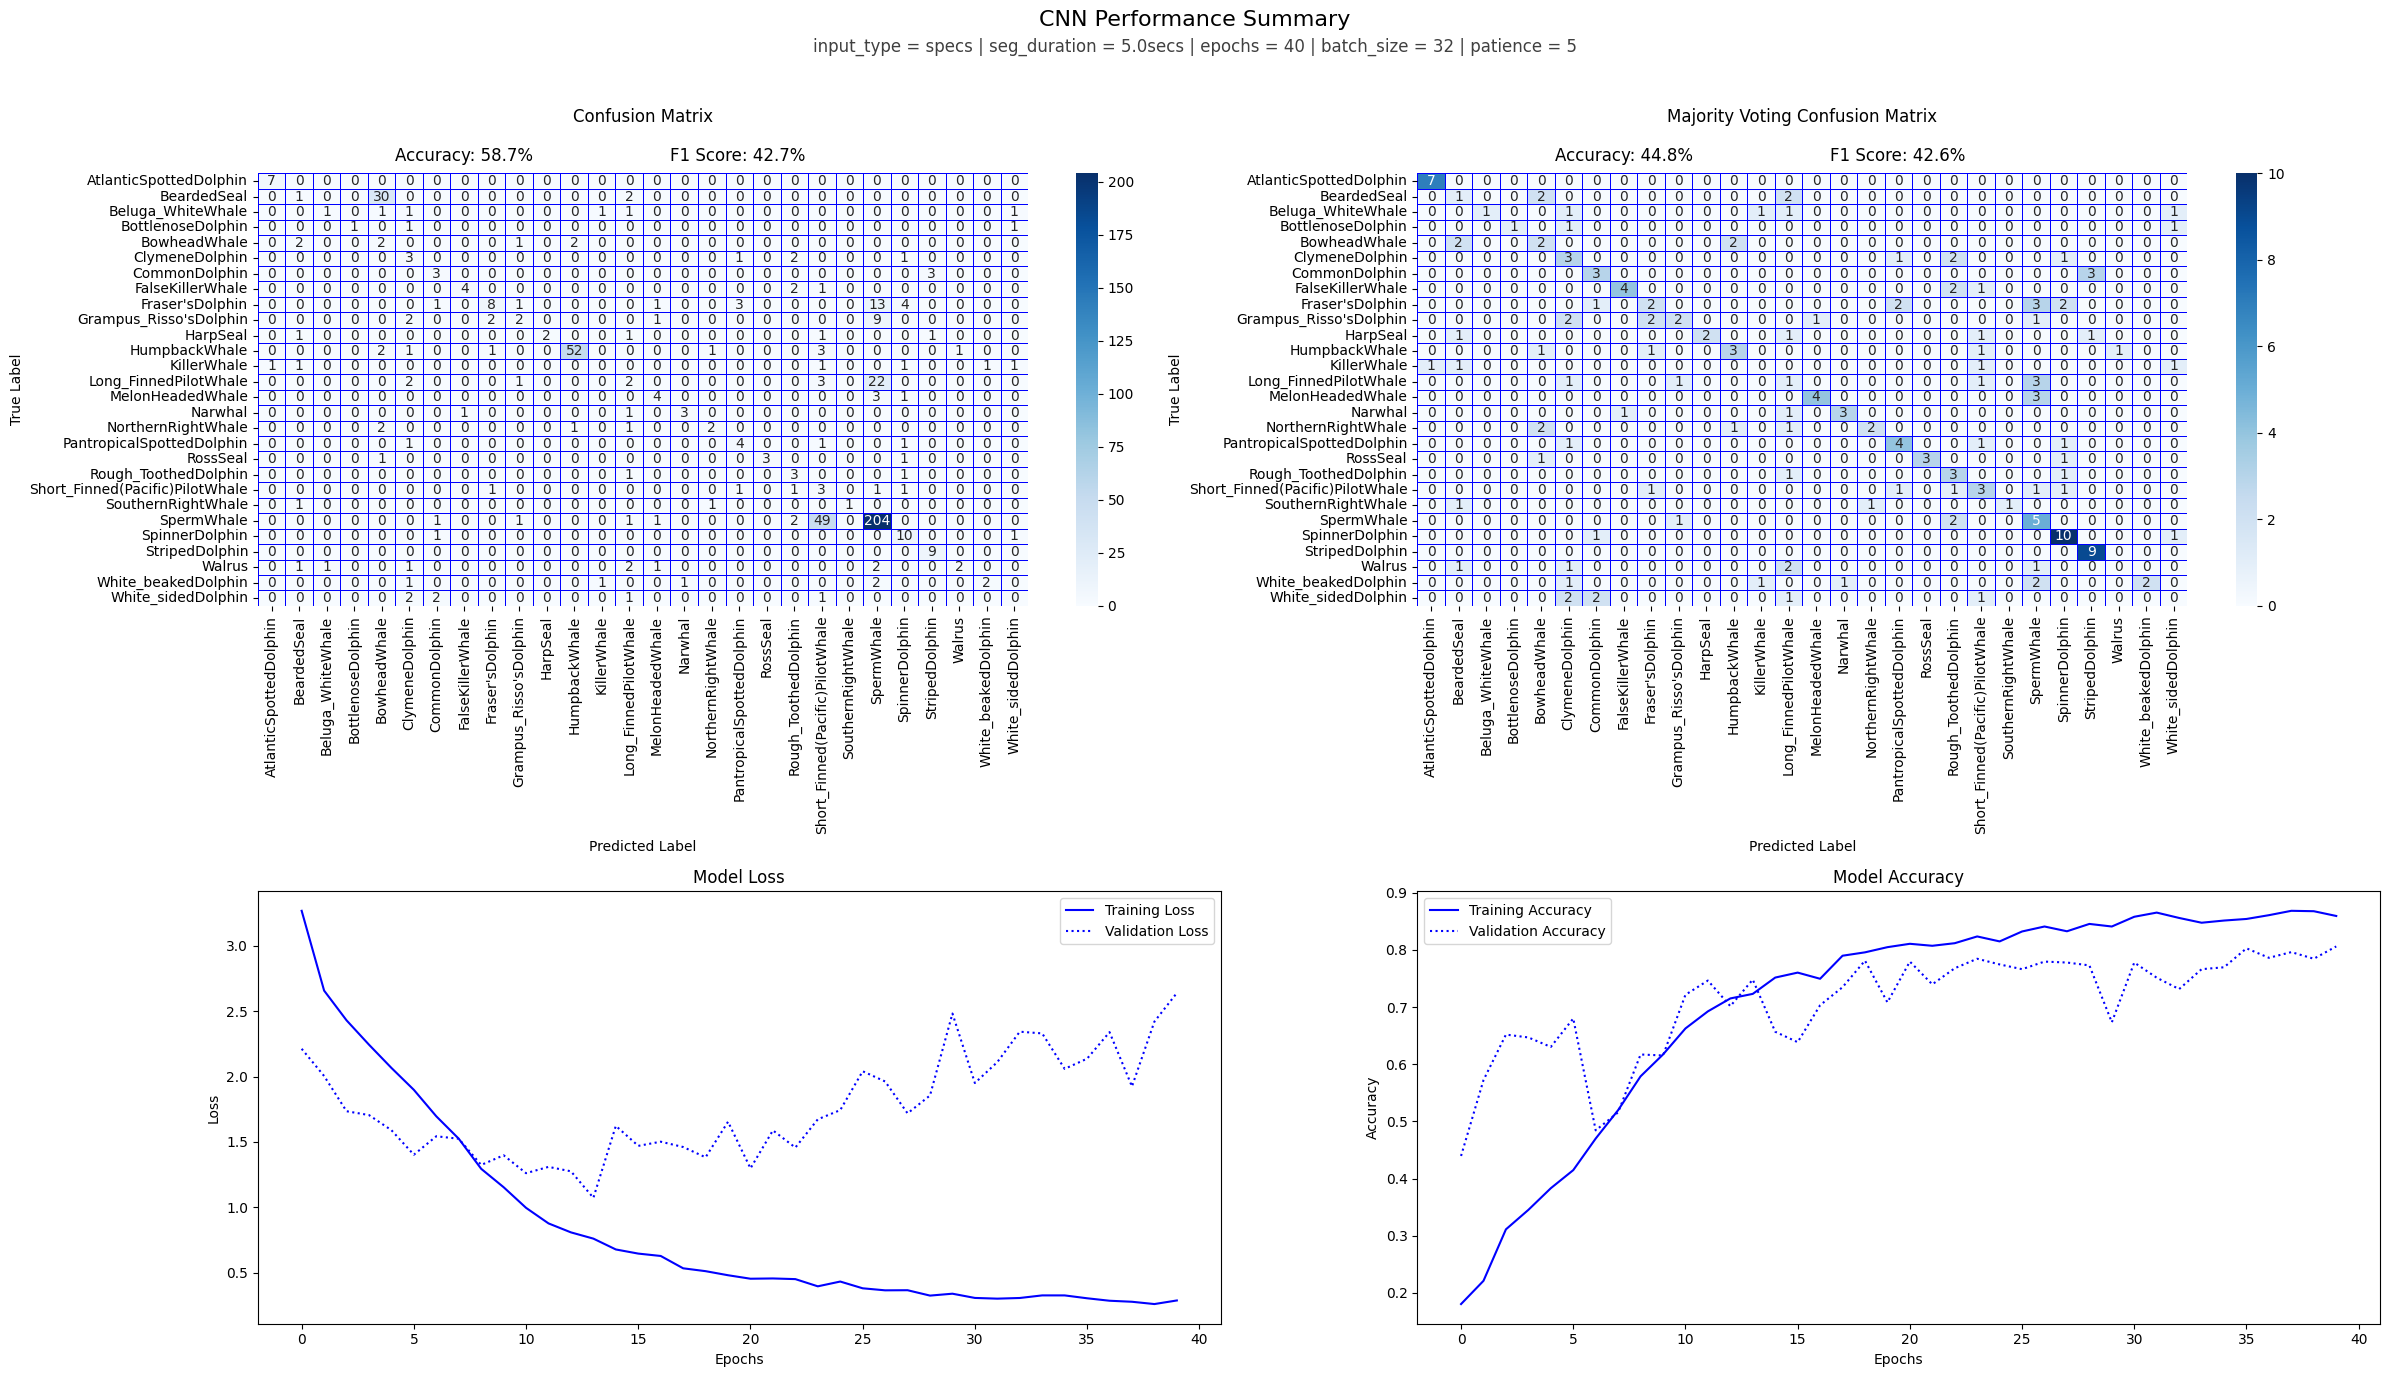

In [16]:
process_pipeline('specs_5.0_40_32_x', 'specs', '5.0', 40, 32)

Epoch 1/40
45/45 [==============================] - 5s 75ms/step - loss: 3.2030 - accuracy: 0.1832 - val_loss: 1.9393 - val_accuracy: 0.4395
Epoch 2/40
45/45 [==============================] - 2s 45ms/step - loss: 2.5407 - accuracy: 0.2544 - val_loss: 1.9487 - val_accuracy: 0.6003
Epoch 3/40
45/45 [==============================] - 2s 43ms/step - loss: 2.3469 - accuracy: 0.3187 - val_loss: 1.6220 - val_accuracy: 0.6451
Epoch 4/40
45/45 [==============================] - 2s 44ms/step - loss: 2.1479 - accuracy: 0.3629 - val_loss: 1.4894 - val_accuracy: 0.6700
Epoch 5/40
45/45 [==============================] - 2s 42ms/step - loss: 1.9836 - accuracy: 0.3879 - val_loss: 1.6440 - val_accuracy: 0.5108
Epoch 6/40
45/45 [==============================] - 2s 44ms/step - loss: 1.7661 - accuracy: 0.4341 - val_loss: 1.5791 - val_accuracy: 0.5191
Epoch 7/40
45/45 [==============================] - 2s 43ms/step - loss: 1.6024 - accuracy: 0.4790 - val_loss: 1.4734 - val_accuracy: 0.6418
Epoch 8/40
45

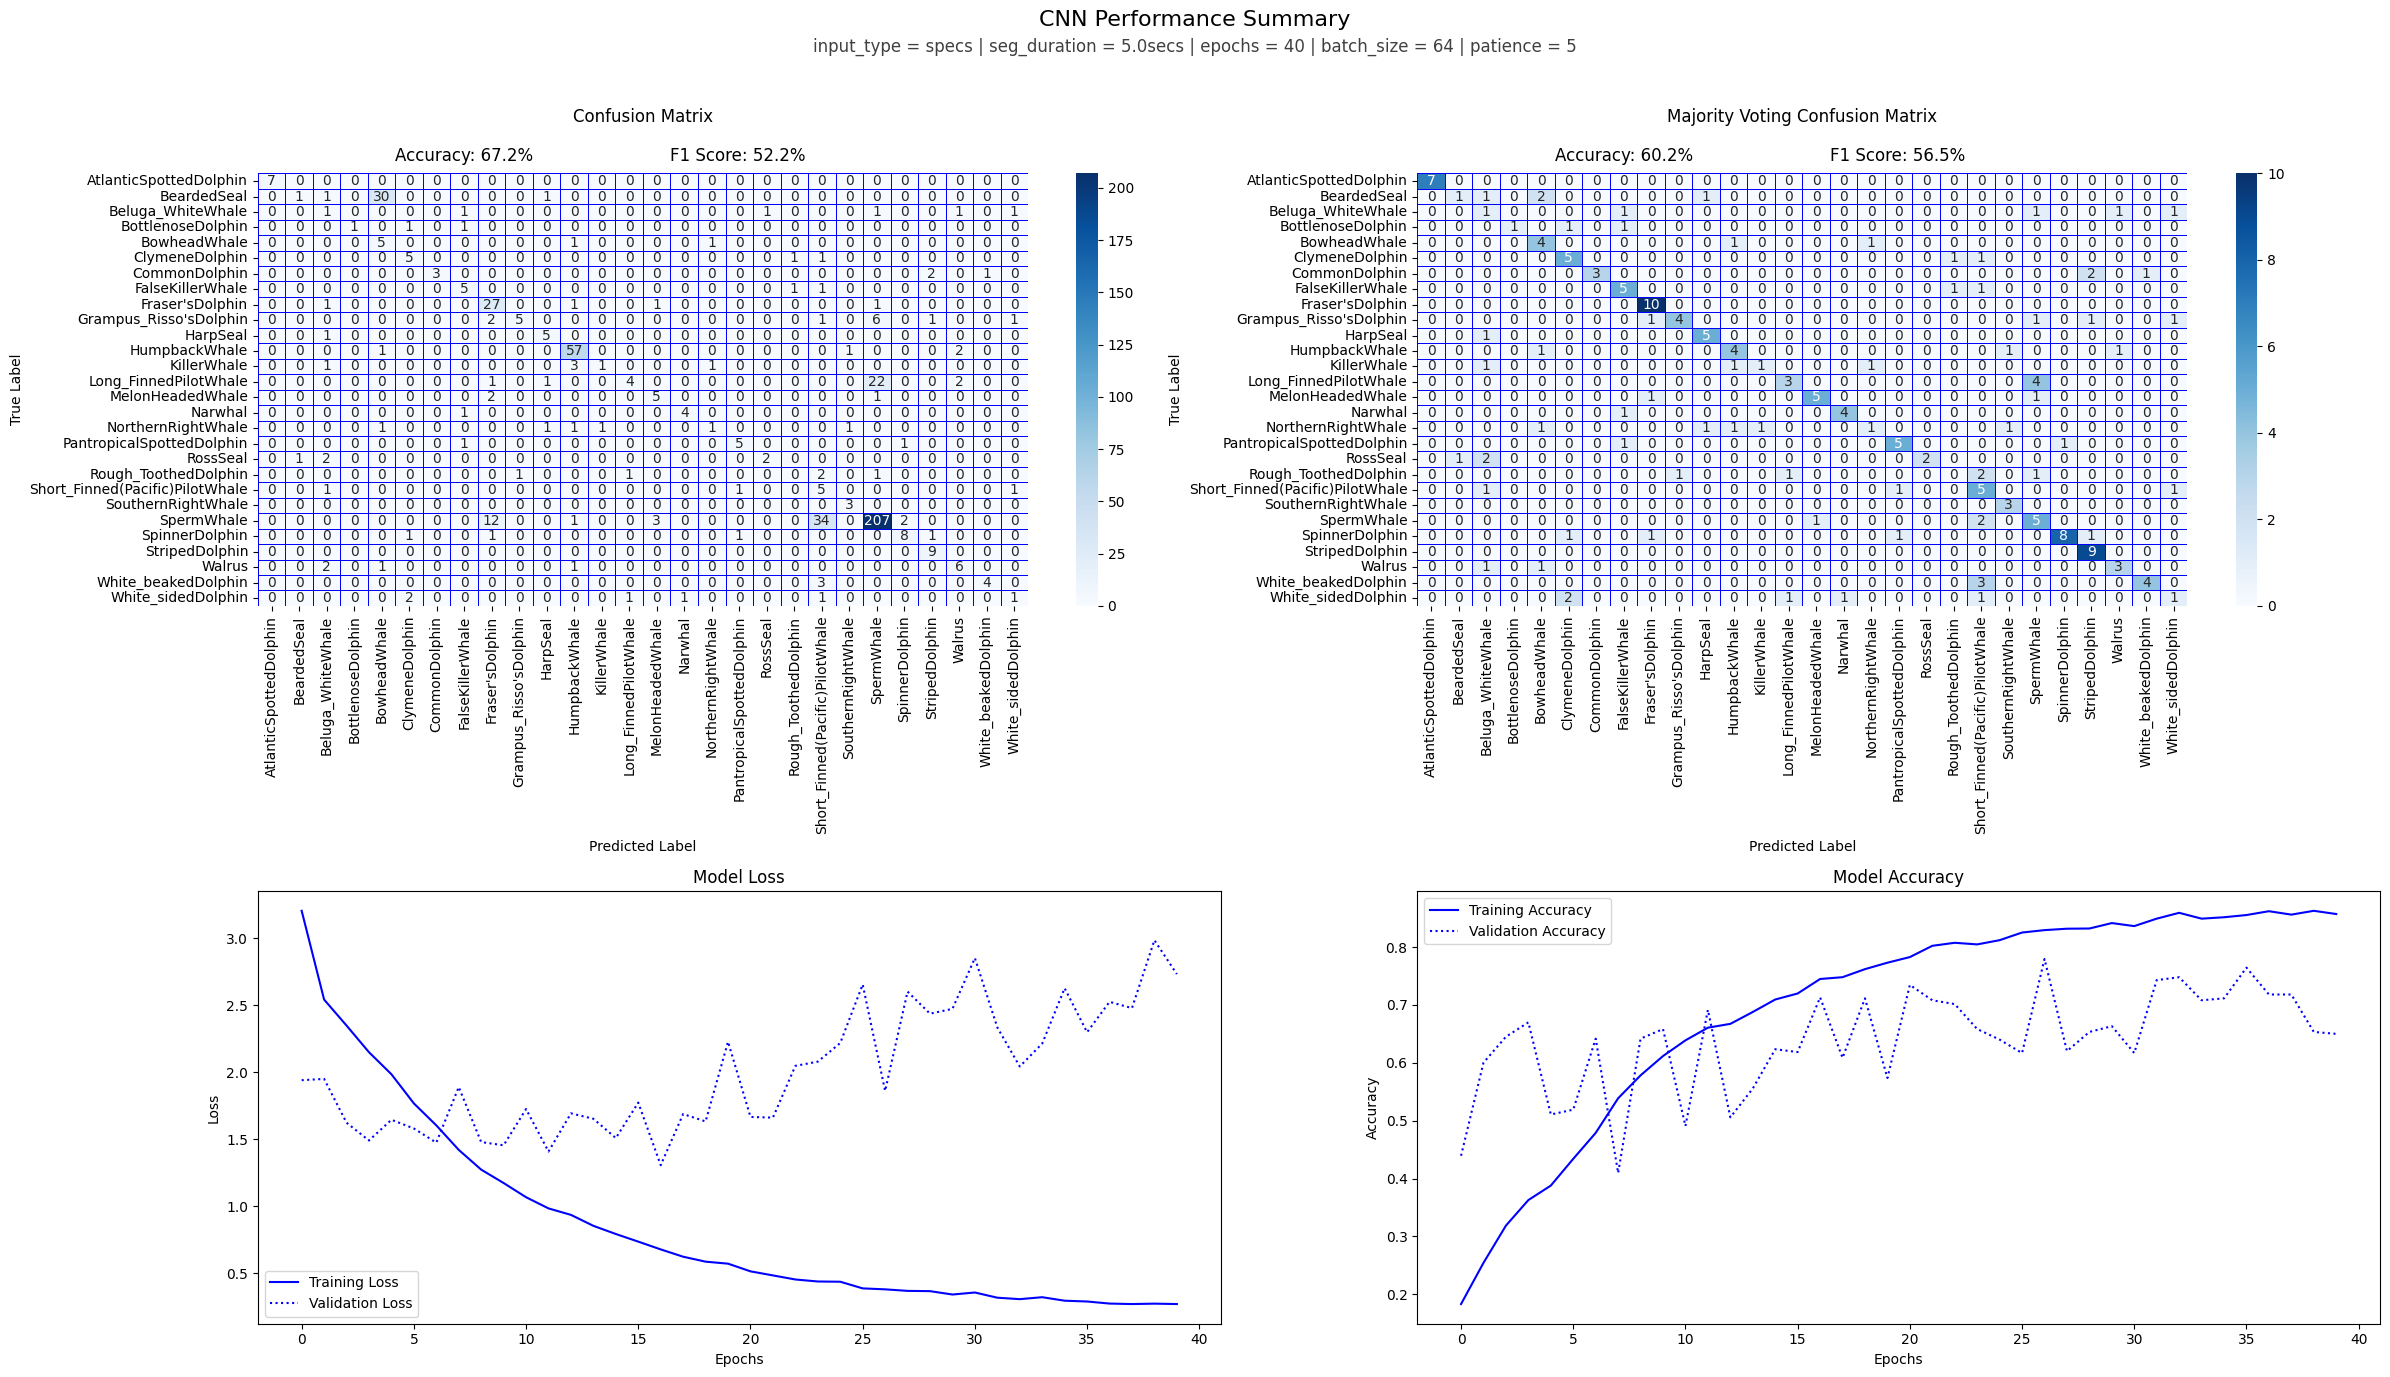

In [17]:
process_pipeline('specs_5.0_40_64_x', 'specs', '5.0', 40, 64)

Epoch 1/40
90/90 [==============================] - 4s 26ms/step - loss: 4.0091 - accuracy: 0.2026 - val_loss: 2.4428 - val_accuracy: 0.2454
Epoch 2/40
90/90 [==============================] - 2s 23ms/step - loss: 2.4447 - accuracy: 0.3027 - val_loss: 2.4176 - val_accuracy: 0.4179
Epoch 3/40
90/90 [==============================] - 2s 24ms/step - loss: 2.0517 - accuracy: 0.4011 - val_loss: 1.7985 - val_accuracy: 0.4743
Epoch 4/40
90/90 [==============================] - 2s 27ms/step - loss: 1.7690 - accuracy: 0.4647 - val_loss: 1.5968 - val_accuracy: 0.5672
Epoch 5/40
90/90 [==============================] - 2s 25ms/step - loss: 1.4486 - accuracy: 0.5474 - val_loss: 1.5721 - val_accuracy: 0.4826
Epoch 6/40
90/90 [==============================] - 2s 24ms/step - loss: 1.2302 - accuracy: 0.6117 - val_loss: 1.5761 - val_accuracy: 0.4925
Epoch 7/40
90/90 [==============================] - 2s 24ms/step - loss: 1.1504 - accuracy: 0.6281 - val_loss: 1.9326 - val_accuracy: 0.4146
Epoch 8/40
90

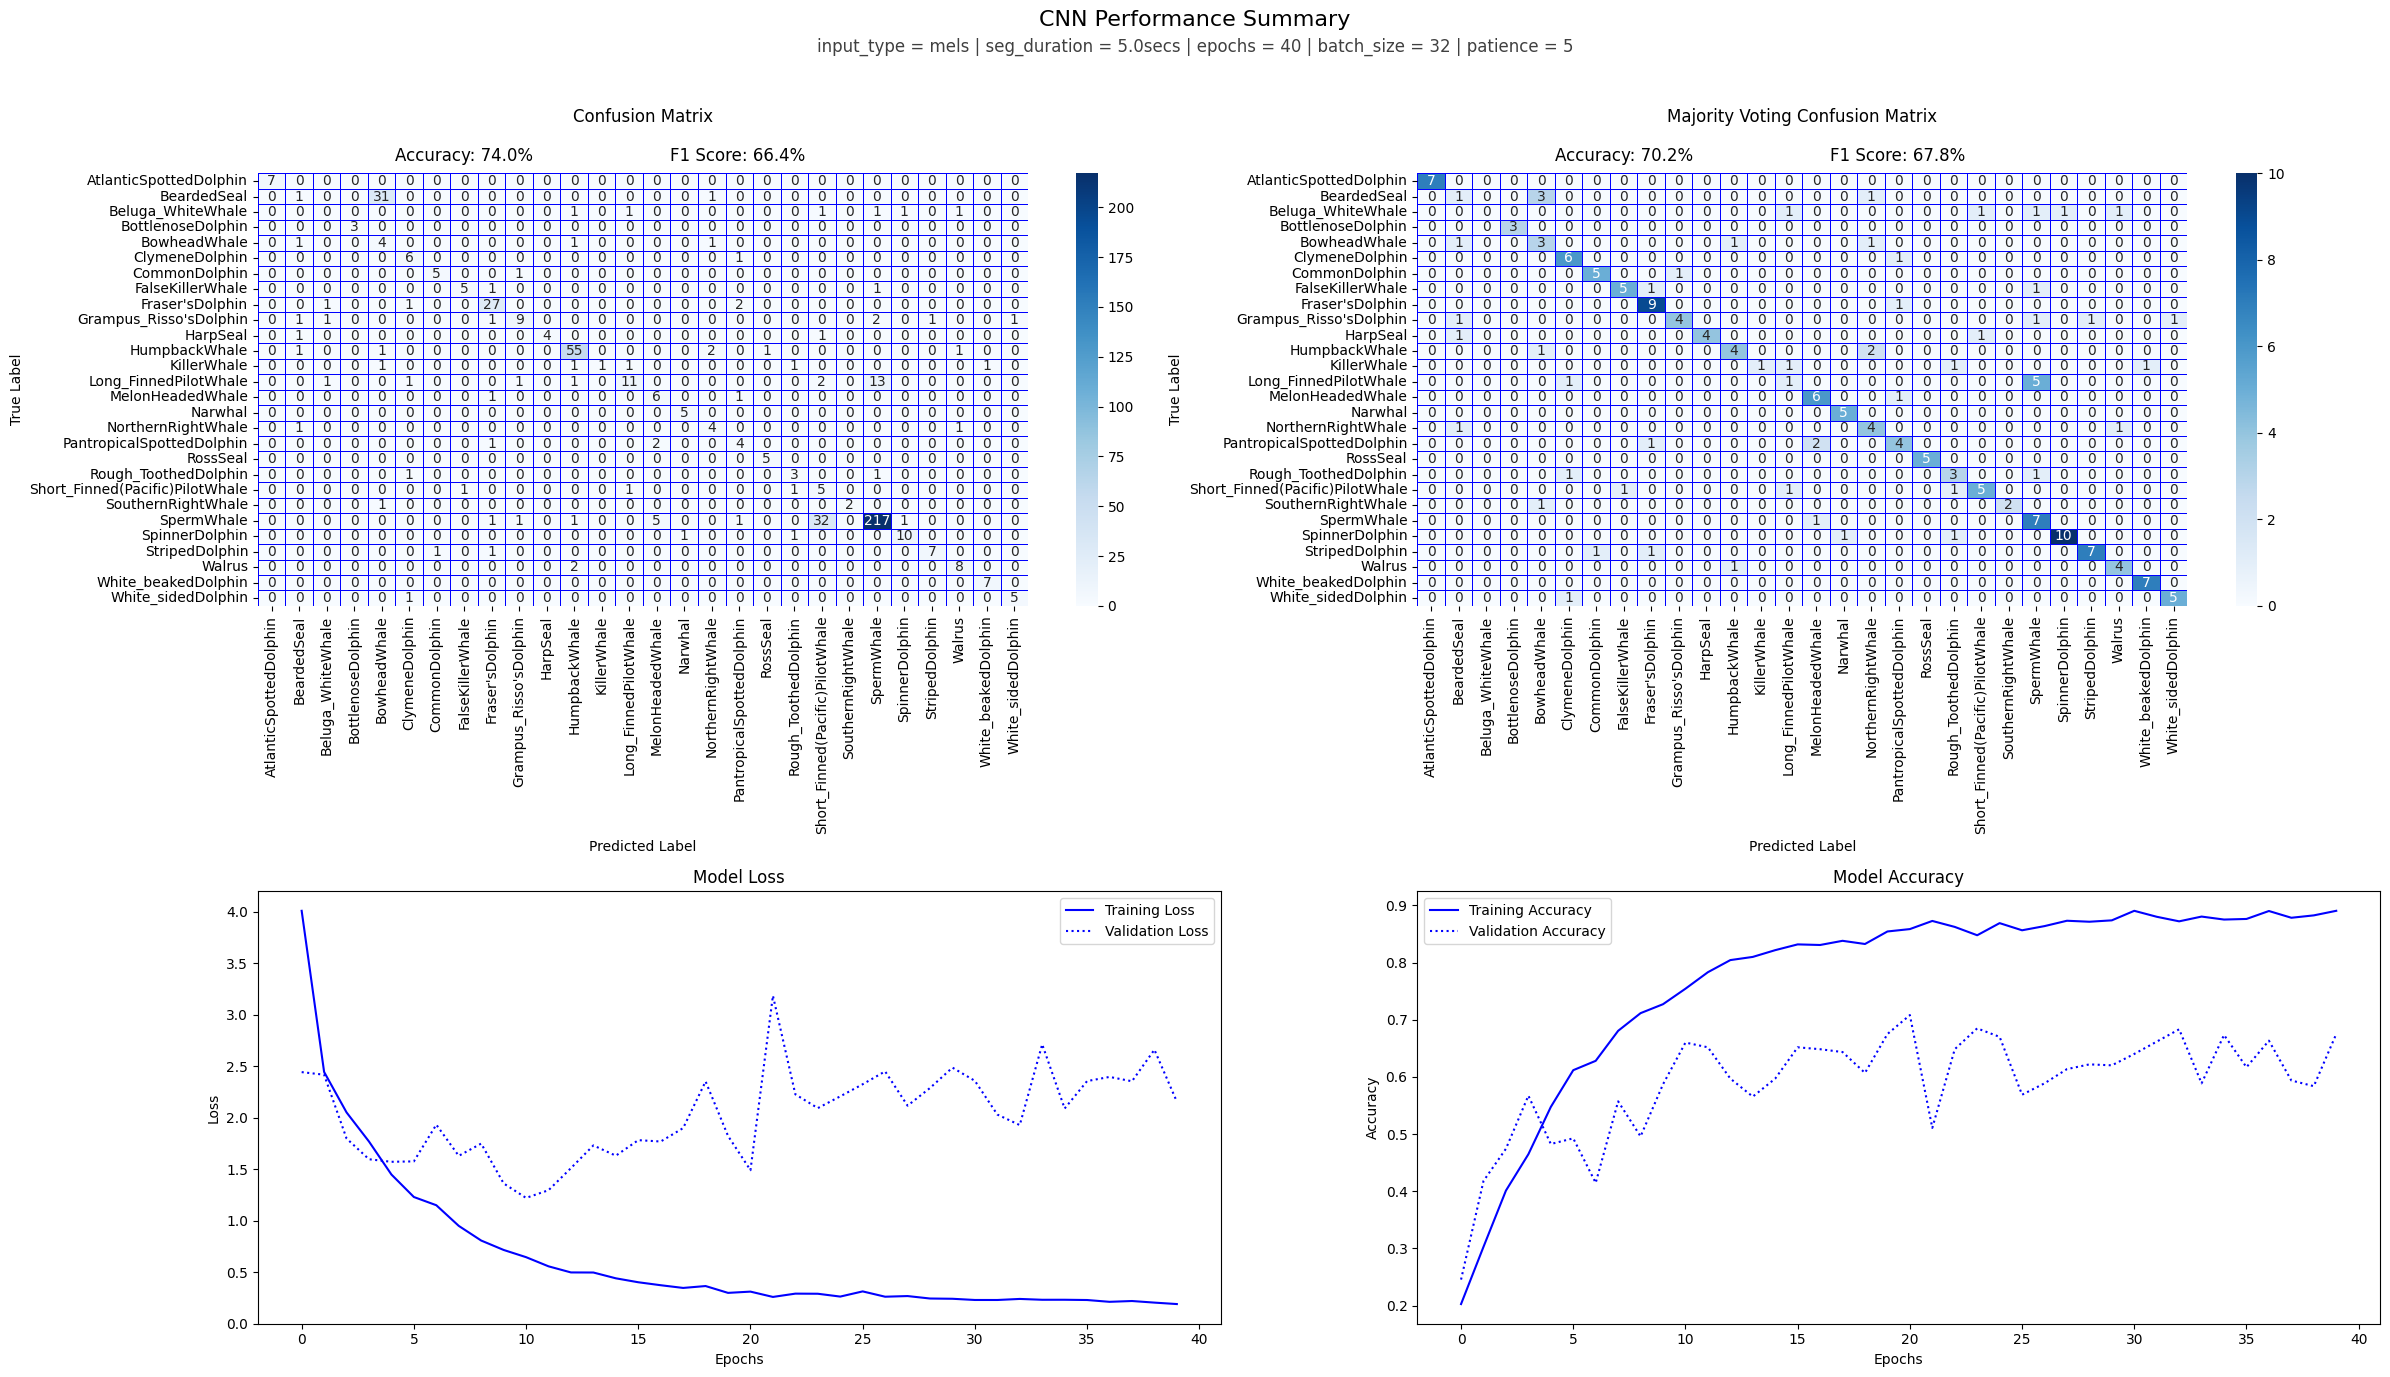

In [18]:
process_pipeline('mels_5.0_40_32_x', 'mels', '5.0', 40, 32)

Epoch 1/40
45/45 [==============================] - 4s 48ms/step - loss: 5.8606 - accuracy: 0.1905 - val_loss: 2.4430 - val_accuracy: 0.3930
Epoch 2/40
45/45 [==============================] - 2s 43ms/step - loss: 2.5368 - accuracy: 0.2948 - val_loss: 1.9846 - val_accuracy: 0.5124
Epoch 3/40
45/45 [==============================] - 2s 42ms/step - loss: 2.2857 - accuracy: 0.3552 - val_loss: 1.7640 - val_accuracy: 0.4544
Epoch 4/40
45/45 [==============================] - 2s 44ms/step - loss: 2.1137 - accuracy: 0.3865 - val_loss: 1.7787 - val_accuracy: 0.5191
Epoch 5/40
45/45 [==============================] - 2s 47ms/step - loss: 1.9446 - accuracy: 0.4171 - val_loss: 1.6799 - val_accuracy: 0.4743
Epoch 6/40
45/45 [==============================] - 2s 44ms/step - loss: 1.7928 - accuracy: 0.4539 - val_loss: 1.6455 - val_accuracy: 0.4776
Epoch 7/40
45/45 [==============================] - 2s 44ms/step - loss: 1.6462 - accuracy: 0.4863 - val_loss: 1.5178 - val_accuracy: 0.4992
Epoch 8/40
45

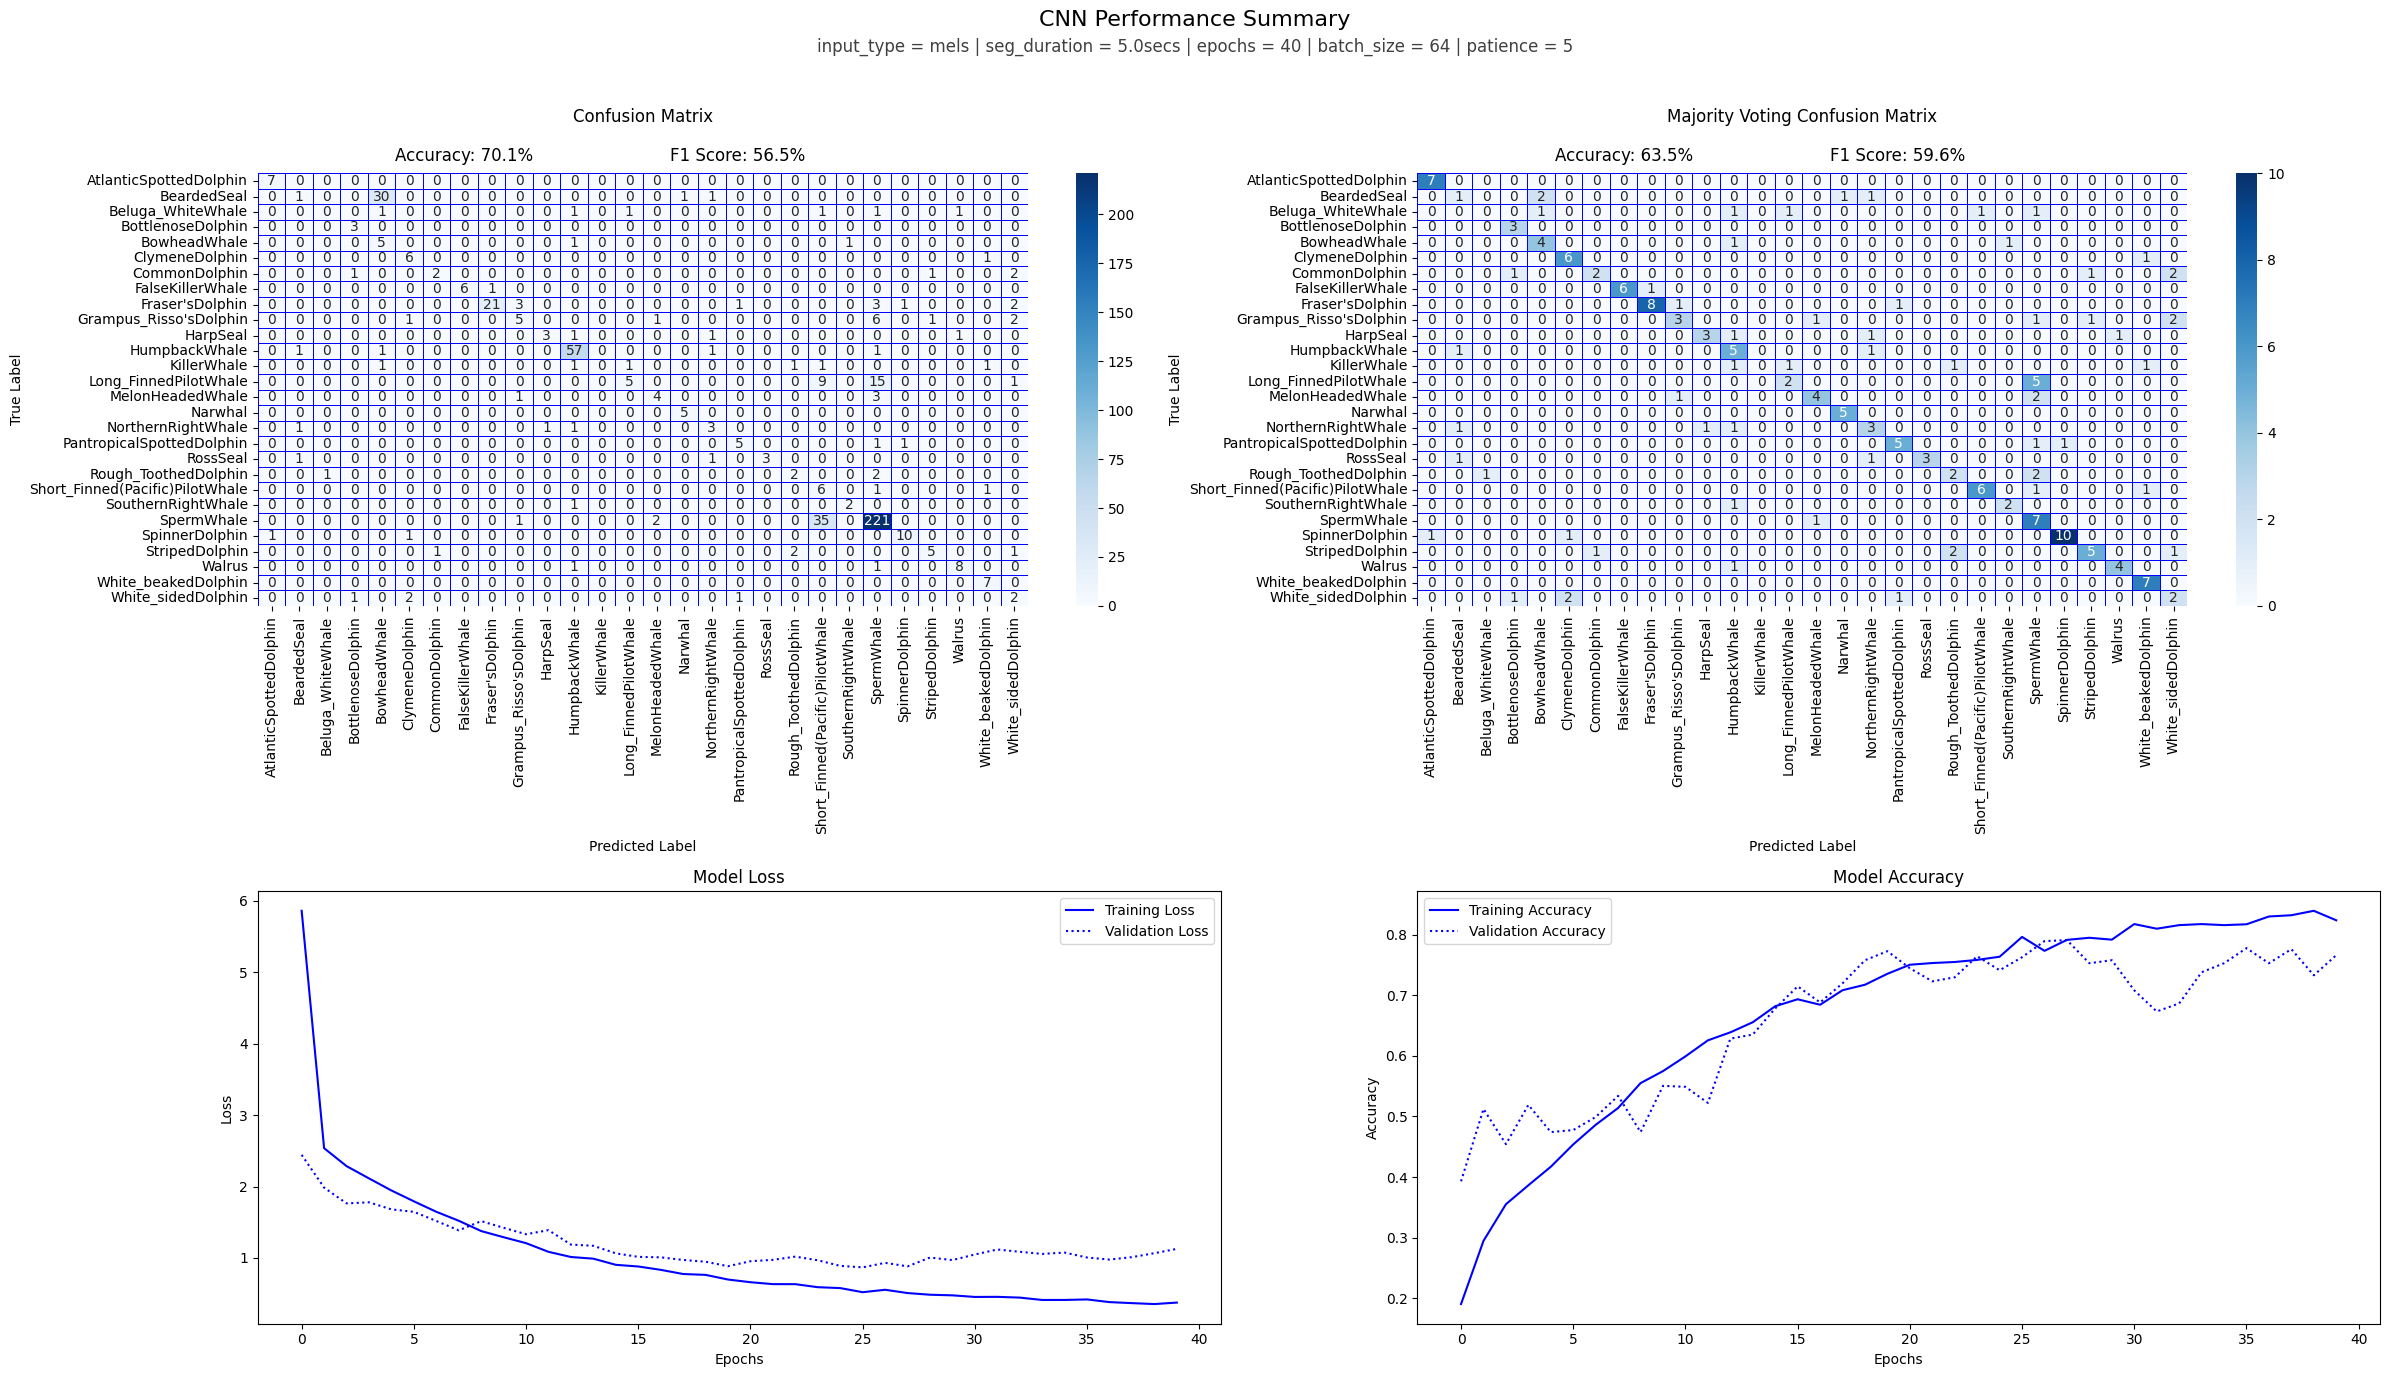

In [19]:
process_pipeline('mels_5.0_40_64_x', 'mels', '5.0', 40, 64)